In [2]:
pip uninstall -y yfinance

Found existing installation: yfinance 0.2.56
Uninstalling yfinance-0.2.56:
  Successfully uninstalled yfinance-0.2.56
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install yfinance --upgrade --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [4]:
import yfinance as yf
import pandas as pd
import os
import json
import time
import logging
import concurrent.futures
import requests
import random
from datetime import datetime, timedelta
from tqdm import tqdm
from typing import Dict, List, Optional


# Paramètres de téléchargement
INTERVALS = ['1m','5m','15m','30m','1h','1d']
# Paramètres système
METADATA_FILE = 'tickers_metadata.json'
DATA_DIR = 'datasets'  # Répertoire des données
DATA_DIR_ENOUGH_DATA = 'datasets_enough_data'
TECH_DATA_DIR = 'datasets_technicals' #Répertoire pour sauvegarder les fichiers avec Indicateurs techniques
EDITED_DATA_DIR = 'datasets_edit'  # Répertoire pour sauvegarder les fichiers modifiés


# Paramètres de priorisation
UPDATE_THRESHOLDS = {
    '1m': timedelta(minutes=15),
    '5m': timedelta(minutes=30),
    '15m': timedelta(hours=1),
    '15m': timedelta(hours=1),
    '30m': timedelta(hours=2),
    '1h': timedelta(hours=4),
    '1d': timedelta(days=1)
}
MAX_CONSECUTIVE_ERRORS = 5
ERROR_COOLDOWN = timedelta(hours=2)
MIN_NB_LINES = 200  # Minimum number of lines required
USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0",
    "Mozilla/5.0 (Linux; Android 10; SM-G970F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Mobile Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36 Edg/109.0.1518.78",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.3 Safari/605.1.15",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36",
    "Mozilla/5.0 (iPhone; CPU iPhone OS 16_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.2 Mobile/15E148 Safari/604.1",
    "Mozilla/5.0 (iPad; CPU OS 16_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) CriOS/109.0.5414.83 Mobile/15E148 Safari/604.1",
    "Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/109.0",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:109.0) Gecko/20100101 Firefox/109.0",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36 OPR/95.0.0.0",
    "Mozilla/5.0 (Linux; Android 13; SM-S908B) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Mobile Safari/537.36"
]



PARIS_TICKERS = [
#CAC40
    "MC.PA","OR.PA","SU.PA","AIR.PA","TTE.PA","SAN.PA","CDI.PA","EL.PA","SAF.PA","AI.PA","BNP.PA","CS.PA","AXA SA","DG.PA","DSY.PA","SGO.PA","BN.PA","ACA.PA","ENGI.PA","KER.PA","HO.PA","CAP.PA","RI.PA","LR.PA","ORA.PA","PUB.PA","GLE.PA",
    "ML.PA","DIM.PA","VIE.PA","AM.PA","BOL.PA","RNO.PA","BVI.PA","AMUN.PA","BIM.PA","AC.PA","EN.PA","ENX.PA","ADP.PA","URW.PA","SW.PA","IPN.PA","RNL.PA","ERF.PA","ALO.PA","CA.PA","FGR.PA","LI.PA","GET.PA","EDEN.PA","RXL.PA","IAM.PA","CBDG.PA","GFC.PA",
    "FDJ.PA","ODET.PA","COTY.PA","AKE.PA","AYV.PA","RF.PA","COV.PA","GTT.PA","SPIE.PA","SPIE SA","TEP.PA","SK.PA","SEB SA","TE.PA","ELIS.PA","Elis SA","SCR.PA","VK.PA","NEX.PA","MF.PA","MLHK.PA","TKO.PA","FLY.PA","SOP.PA",
    "DEC.PA","PLX.PA","ITP.PA","VRLA.PA","SOI.PA","RCO.PA","COVH.PA","MMB.PA","ATE.PA","VU.PA","FR.PA","IDL.PA","BB.PA","RUI.PA","VIRP.PA","TRI.PA","BAIN.PA","VIV.PA","COFA.PA","CARM.PA","LOUP.PA","NK.PA","WLN.PA","ALTA.PA","UNBL.PA","IPS.PA",
    "CAF.PA","AF.PA","PLNW.PA","CBE.PA","VCT.PA","PEUG.PA","RBT.PA","EXN.PA","STF.PA","STEF SA","ICAD.PA","SESG.PA","OPM.PA","ERA.PA","ARG.PA","TFI.PA","TF1 SA","UBI.PA","OVH.PA","MMT.PA","ES.PA","BLV.PA","MAU.PA","GDS.PA","FII.PA","WAVE.PA",
    "CRLA.PA","NRO.PA","LSS.PA","MERY.PA","ETL.PA","ELEC.PA","FREY.PA","DBG.PA","CNDF.PA","LTA.PA","CDA.PA","FNAC.PA","MTU.PA","VETO.PA","TKTT.PA","VIL.PA","BEN.PA","EC.PA","VAC.PA","SAVE.PA","BASS.PA","NXI.PA","XFAB.PA","SDG.PA",
    "THEP.PA","CRAV.PA","CRSU.PA","CRAP.PA","CEN.PA","SCHP.PA","TFF.PA","KOF.PA","QDT.PA","LPE.PA","SBT.PA","EQS.PA","BUR.PA","AUB.PA","GLO.PA",
]

US_ETF = ["SOXL","SPXS","FXI","TSLL","TSLZ","SQQQ","TQQQ","SOXS","ETHU","NVDQ","SPY","KWEB","IBIT","MSTU","XLF","EEM","TLT","HYG","UVXY","EWZ","TZA","QQQ","IWM","SLV","FAZ","LQD","NVDL","LABD","AMDL","SDS","MSTZ","GDX","NVDX","SCHD","VEA","EFA","TNA","SPXU",
          "YINN","SCHF","XBI","KRE","BITX","XLE","XLV","BITO","USHY","IEMG","SCHX","XLI","UVIX","ARKK","ASHR","IEFA","EMXC","GLD","RWM","VOO","VWO","MCHI","IJH","ETHA","NVDD","XLP","MSTX","JAAA","SCHG","EWJ","XLU","SMH","IAU","TSLS","SGOL","QID","QYLD","XLB",
          "XRT","NVD","SGOV","RSP","TMF","KORU","TSLQ","BND","BIL","AGG","BKLN","SCHH","SPLG","UNG","EMLC","INDA","FEZ","CONY","SCHB","SPTI","YANG","VCIT","FNGD","GOVT","IGV","MSOS","SPDN","SRTY","GDXJ","SBIT","IQLT","VXX","SHV","PSQ","EMB","VXUS","DRIP","JEPQ",
          "IYR","VTEB","SPIB","IEF","MSTY","JPST","UPRO","FBTC","XLK","SPDW","EWH","JEPI","ILF","PGX","CONL","IJR","IYZ","SPHY","CGGR","GGLL","EWY","KOLD","SCHP","VTI","CGDV","SHY","ITB","SILJ","IVV","SPTL","BITU","SOXX","SRLN","SPXL","SDOW","XHB","TIP","EZA",
          "ETHE","XLC","FBND","VGIT","USFR","ULTY","VCRB","HEFA","GBTC","ARKG","TSLY","VGSH","XLY","SJNK","ACWI","ICLN","VTV","AMZU","MAGS","AGQ","GLDM","XOP","JCPB","VNQ","SCHA","PFF","PAVE","PDBC","EFV","QQQM","BNDX","DOG","BOIL","EWT","IUSB","EZU","BITB",
          "SPYV","JNK","SSO","BSCT","BABX","DIA","QLD","IBB","XME","RSHO","EWW","SPSM","SCHO","EWC","VEU","CALF","SCHM","SPYG","USO","BITI","TSLT","VGK","MUB","SPMD","COWZ","ETH","TMV","COPX","UDOW","AMLP","URA","NVDY","KBWB","PULS","EWA","BSV","IDEV","EWG",
          "CLOZ","VMBS","SPTS","IXUS","SVIX","VIXY","DFAC","SDVY","TFLO","SCHZ","MLPX","SPEM","SPSB","LABU","DYNF","IGSB","CGUS","ETHT","BLV","BBJP","UCO","YMAX","IAUM","VCSH","AAAU","VGLT","VTWO","SPMO","TSLR","DGRO","SPAB","KBE","AUSF","PYLD","VCLT","NVDU",
          "JETS","IWD","CWEB","FNDF","SCHR","DXD","FLOT","IGIB","BIV","JBBB","MOAT","DFIC","MBB","URNM","TBIL","QEFA","SCHE","PVAL","FGD","IEUR","XLG","NUGT","IVW","BUFR","DFSV","OUNZ","SCHI","VFLO","CQQQ","DFAI","FETH","SPLV","NVDS","GRNY","MSFU","AAPU","IEI",
          "EEMA","CIBR","CGCP","ITOT","SHYG","BSCR","IWF","TECL","RDVY","QGRW","FPE","PXH","BAR","TFI","IWP","BINC","MTUM","UUP","ACWX","PZA","GDXD","MINT","AAPD","YMAG","SPLB","IWR","USMV","TECS","VUG","ACES","QUAL","IGLB","SVXY","SCHV","BTC","IYT","AMDY","FAS",
          "AVGX","SPYD","MRNY","ARKB","VIG","ZSL","URTY","NAIL","DFLV","TCAF","ITA","KIE","URNJ","HYD","TSDD","SPYI","VUSB","VTIP","FDVV","HTRB","SCO","FTSM","AMZZ","FLTR","BIZD","PTIR","DIVO","COWG","VSS","FBL","DFEM","EPI","IOO","AVUV","VONG","VYM","FNDE","SPHQ",
          "FLRN","HYEM","MDY","SIVR","USIG","DUST","DIVI","BUG","IWB","GSLC","UCON","CHAU","AVDV","BOTZ","JDST","FNDA","IBDQ","GUNR","PAAA","AIQ","VWOB","SIL","JNUG","DBA","SCZ","DUHP","SVOL","AVEM","CGMS","DFSD","HYLB","TWM","FENY","DFCF","GDXU","XSMO","AMZY","REM"
          ,"DRN","SLYV","IYW","BSCP","BSCQ","AIYY","CGBL","DBEF","FELC","GLL","EWU","FNGU","WEAT","DFAE","USD","CGGO","EDZ","GBIL","IUSV","EFG","BTCZ","IBDV","SPTM","SPYU","DPST","OIH","EDV","AMZD","DJAN","FALN","EUFN","PFFD","METU","AIRR","ETHD","TLTW","DFAU",
          "CETH","VFH","FBCG","IDV","BSCS","GSY","ICSH","ESGE","JGRO","DBC","CTA","FIAT","SDIV","AVL","FHLC","CGXU","IBDU","LVHI","IBDS","SCHK","BUFD","DFAX","TLH","JMST","FJP","IBDR","DFIV","DGRW","FIXD","RYLD","QDTE","EVTR","FLCB","BBIN","JMEE","WGMI","SPGP",
          "HYMB","JPIE","IWN",]

EU_ETF = ["BX4.PA","BXX.PA","WPEA.PA","DSD.PA","AUEM.PA","MSE.PA","ESE.PA","SHC.PA","AEEM.PA","MFEC.PA","DFND-EUR.PA","BNKE.PA","LVC.PA","500U.PA","LCWD.PA","PSP5.PA","GRE.PA","ESEH.PA","CL2.PA","ISRA.PA","BNK.PA","ETZ.PA","PASI.PA","SEME.PA","ETZD.PA",
          "CNY.PA","PAASI.PA","PSPH.PA","ESD.PA","ABDJI.PA","ABNSP.PA","AABCH.PA","AATCX.PA","AAHLT.PA","ABSMI.PA","CACC.PA","PUST.PA","AAFIN.PA","AABFB.PA","GEMU.PA","AARTL.PA","OBLI.PA","8G19V.PA","NB22V.PA","NB28V.PA","SPEEU.PA","ERTH.PA","AABEN.PA",
          "ABDJE.PA","ABHSN.PA","AAUTL.PA","AAINS.PA","HSTE.PA","SP5.PA","AASTX.PA","ABNSQ.PA","BRES.PA","PE500.PA","HEMA.PA","AABKX.PA","PAEEM.PA","EEE.PA","AATLC.PA","E40.PA","MUSRI.PA","ESDD.PA","XQ48V.PA","CAC.PA","UST.PA","EEMK.PA","CEC.PA",
          "EGRI.PA","ETHC-EUR.PA","0G28.IL","0Y4H.IL","0MPR.IL","WDTE.L","0MPY.IL","TS3S.L","0A09.L","XT2D.L","0DZF.IL","CNYA.L","SUOE.L","FRXD.L","WHCE.L","XSD2.L","0HOV.IL","ISF.L","JCAU.L","N100.L","0Y8R.IL",
          "DTLA.L","0MRJ.IL","IBTA.L","SUSW.L","SPEH.L","HIGG.L","0XC5.IL","HAGG.L","UC76.L","FBTC.L","AGBP.L","MIDD.L","FUSR.L","0DZB.L","DTLE.L","0MMG.IL","IGLT.L","0Y2B.L","SDIA.L","IEBB.IL","0GBX.IL","JCPN.L",
          "IHYA.L","EWSX.L","0L4R.L","HYLA.L","IDTL.L","EWSP.L","IUIT.L","WNDI.L","0DYZ.IL","0HEP.L","PAWD.L","HCGU.L","0MP3.IL","SNGB.L","0WA3.IL","MTHG.L","FLOA.L","EMAU.L","LQDA.L","HGAS.L","IEAC.L",
          "V3SU.L","AREG.L","0H9U.L","NDIA.L","FWRG.L","IGTM.L","TSLQ.L","GDMS.L","0WA5.IL","UIFS.L","XGSI.L","0KZC.L","BS0A.L","XDNS.L","I50D.L","QQQ5.L"]

CURRENCY_AND_FUTURES = ["ZN=F","ZF=F","ES=F","ZT=F","NQ=F","ZB=F","CL=F","GC=F","ZC=F","RTY=F","NG=F","MGC=F","YM=F","ZS=F","HG=F","SI=F","SB=F","HO=F","RB=F","ZL=F","KE=F","ZM=F","BZ=F","CT=F","KC=F","PL=F","LE=F","SIL=F",
                        "HE=F","CC=F","GF=F","PA=F","EURUSD=X","JPY=X","GBPUSD=X","AUDUSD=X","NZDUSD=X","EURJPY=X","GBPJPY=X","EURGBP=X","EURCAD=X","EURSEK=X","EURCHF=X","EURHUF=X","CNY=X","HKD=X",
                        "SGD=X","INR=X","MXN=X","PHP=X","IDR=X","THB=X","MYR=X","ZAR=X","RUB=X"]

US_TICKERS = [
    #US main tickers
'NVDA','AAPL','MSFT','AMZN','GOOGL','GOOG','META','TSLA','AVGO','BRK-B','ORCL','TCEHY','TCTZF','NFLX','COST','NONOF','LVMHF','LVMUY','JPM-PD','JPM-PC','BML-PG','SAPGF','BML-PH','BML-PL','BAC-PE','IDCBY','BAC-PK','SSNLF','ABBV','IDCBF','HESAY','ASMLF','ASML','GDVTZ',
    'ACGBF','TMUS','BML-PJ','BAC-PB','RHHBF','CSCO','RHHVF','RHHBY','TOYOF','ACGBY','BABAF','AZNCF','BABA','NSRGY','NSRGF','ISRG','CICHY','RYDAF','BACHY','LRLCY','WFC-PY','NVSEF','BACHF','SHEL','CICHF','LRLCF','PCCYF','ADBE','QCOM','HBCYF','HSBC','CMWAY','PLTR','SIEGY',
    'SMAWF','INTU','ANET','CBAUF','IDEXF','SBGSF','SPGI','IDEXY','SBGSY','MBFJF','DTEGF','AMAT','DTEGY','FMXUF','SCHW','CIHKY','MUFG','AMGN','UBER','CMCSA','UNLYF','SHOP','EADSF','EADSY','BHPLF','SNYNF','TTFNF','SNEJF','CHDRY','CILJF','SONY','CHDRF',
    'WFC-PC','ALIZF','ALIZY','HTHIF','ESLOY','RTNTF','HTHIY','MPNGF','Meituan','ESLOF','CIHHF','XIACY','MPNGY','Meituan','PNGAY','XIACF','CIIHF','GILD','PIAIF','VRTX','BYDDF','BYDDY','SBUX','SAFRF','SAFRY','CFRUY','CUAEF','CFRHF','ABBNY','ABLZF','MRVL','KYCCF','RCRUY',
    'UNCFF','UNCRY','CSUAY','SPOT','FRCOF','RCRRF','LRCX','KLAC','SMFNF','SNPMF','SFTBF','FRCOY','AIQUY','AIQUF','SFTBY','SMFG','RTPPF','BUDFF','USB-PH','IBKR','CRWD','DBSDY','RLXXF','EQIX','RELX','INTC','INFY','IVSXF','PYPL','EBBNF','DBSDF','PROSF','PROSY','GS-PA','IBDRY',
    'IBDSF','CDNS','NPPXF','IVSBF','ZFSVF','MS-PA','ZURVY','WELL','BNPQF','BNPQY','SNPS','ATLCY','TOELF','BPAQF','AXAHF','AXAHY','CSLLY','MSTR','CMXHF','ATLKY','MS-PK','TOELY','GS-PD','MS-PI','PBR-A','NTTYY','MS-PF','IITSF','BTAFF','BCDRF','DELL','CTAS','ABNB','MS-PE','AAIGF',
    'LNSTY','LDNXF','ISNPY','RACE','MDLZ','HNHPF','AAGIY','SCCO','DASH','CGXYY','PBCRF','USB-PP','COIN','NTDOF','SBKFF','FTNT','REGN','NTDOY','MURGY','MURGF','PBCRY','ESOCF','WEBNF','ENLAY','NABZY','BKFCF','PSTVY','GLAXF','BCMXY','TEAM','CHGCY','TKOMF','CHGCF','PSBKF','WDAY',
    'ITOCF','RLLCF','MKGAF','NTES','MKKGY','SHECY','BBVXF','ITOCY','STOHF','RBSPF','TKOMY','DGEAF','EQNR','PPWLM','ADSK','BBVA','RYCEF'
]

# Liste noire de tickers problématiques à exclure
BLACKLISTED_TICKERS = {
    'AXA SA',  # Format incorrect, utiliser CS.PA à la place
    # Vous pouvez ajouter d'autres tickers problématiques ici
}


# Liste de tickers (sans leverage)
TICKERS =['^GSPC','^FCHI','MC.PA', 'OR.PA', 'SU.PA', 'AIR.PA', 'TTE.PA', 'SAN.PA', 'CDI.PA', 'EL.PA', 'SAF.PA', 'AI.PA', 'BNP.PA', 'CS.PA', 'DG.PA', 'DSY.PA', 'SGO.PA', 'BN.PA', 'ACA.PA', 'ENGI.PA', 'KER.PA', 'HO.PA', 'CAP.PA', 'RI.PA', 'LR.PA', 'ORA.PA', 'PUB.PA',
          'GLE.PA', 'ML.PA', 'DIM.PA', 'VIE.PA', 'AM.PA', 'BOL.PA', 'RNO.PA', 'BVI.PA', 'AMUN.PA', 'BIM.PA', 'AC.PA', 'EN.PA', 'ENX.PA', 'ADP.PA', 'URW.PA', 'SW.PA', 'IPN.PA', 'RNL.PA', 'ERF.PA', 'ALO.PA', 'CA.PA', 'FGR.PA', 'LI.PA', 'GET.PA', 'EDEN.PA',
          'RXL.PA', 'IAM.PA', 'CBDG.PA', 'GFC.PA', 'FDJ.PA', 'ODET.PA', 'COTY.PA', 'AKE.PA', 'AYV.PA', 'RF.PA', 'COV.PA', 'GTT.PA', 'SPIE.PA', 'TEP.PA', 'SK.PA', 'TE.PA', 'ELIS.PA', 'SCR.PA', 'VK.PA', 'NEX.PA', 'MF.PA', 
          'MLHK.PA', 'TKO.PA', 'FLY.PA', 'SOP.PA', 'DEC.PA', 'PLX.PA', 'ITP.PA', 'VRLA.PA', 'SOI.PA', 'RCO.PA', 'COVH.PA', 'MMB.PA', 'ATE.PA', 'VU.PA', 'FR.PA', 'IDL.PA', 'BB.PA', 'RUI.PA', 'VIRP.PA', 'TRI.PA', 'BAIN.PA', 'VIV.PA', 'COFA.PA', 'CARM.PA',
          'LOUP.PA', 'NK.PA', 'WLN.PA', 'ALTA.PA', 'UNBL.PA', 'IPS.PA', 'CAF.PA', 'AF.PA', 'PLNW.PA', 'CBE.PA', 'VCT.PA', 'PEUG.PA', 'RBT.PA', 'EXN.PA', 'STF.PA', 'ICAD.PA', 'SESG.PA', 'OPM.PA', 'ERA.PA', 'ARG.PA', 'TFI.PA', 'UBI.PA', 'OVH.PA',
          'MMT.PA', 'ES.PA', 'BLV.PA', 'MAU.PA', 'GDS.PA', 'FII.PA', 'WAVE.PA', 'CRLA.PA', 'NRO.PA', 'LSS.PA', 'MERY.PA', 'ETL.PA', 'ELEC.PA', 'FREY.PA', 'DBG.PA', 'CNDF.PA', 'LTA.PA', 'CDA.PA', 'FNAC.PA', 'MTU.PA', 'VETO.PA', 'TKTT.PA', 'VIL.PA', 'BEN.PA',
          'EC.PA', 'VAC.PA', 'SAVE.PA', 'BASS.PA', 'NXI.PA', 'XFAB.PA', 'SDG.PA', 'THEP.PA', 'CRAV.PA', 'CRSU.PA', 'CRAP.PA', 'CEN.PA', 'SCHP.PA', 'TFF.PA', 'KOF.PA', 'QDT.PA', 'LPE.PA', 'SBT.PA', 'EQS.PA', 'BUR.PA', 'AUB.PA', 'GLO.PA', 'NVDA', 'AAPL', 'MSFT',
          'AMZN', 'GOOGL', 'GOOG', 'META', 'TSLA', 'AVGO', 'BRK-B', 'ORCL', 'TCEHY', 'TCTZF', 'NFLX', 'COST', 'NONOF', 'LVMHF', 'LVMUY', 'JPM-PD', 'JPM-PC', 'BML-PG', 'SAPGF', 'BML-PH', 'BML-PL', 'BAC-PE', 'IDCBY', 'BAC-PK', 'SSNLF', 'ABBV', 'IDCBF', 'HESAY',
          'ASMLF', 'ASML', 'GDVTZ', 'ACGBF', 'TMUS', 'BML-PJ', 'BAC-PB', 'RHHBF', 'CSCO', 'RHHVF', 'RHHBY', 'TOYOF', 'ACGBY', 'BABAF', 'AZNCF', 'BABA', 'NSRGY', 'NSRGF', 'ISRG', 'CICHY', 'RYDAF', 'BACHY', 'LRLCY', 'WFC-PY', 'NVSEF', 'BACHF', 'SHEL', 'CICHF',
          'LRLCF', 'PCCYF', 'ADBE', 'QCOM', 'HBCYF', 'HSBC', 'CMWAY', 'PLTR', 'SIEGY', 'SMAWF', 'INTU', 'ANET', 'CBAUF', 'IDEXF', 'SBGSF', 'SPGI', 'IDEXY', 'SBGSY', 'MBFJF', 'DTEGF', 'AMAT', 'DTEGY', 'FMXUF', 'SCHW', 'CIHKY', 'MUFG', 'AMGN', 'UBER', 'CMCSA',
          'UNLYF', 'SHOP', 'EADSF', 'EADSY', 'BHPLF', 'SNYNF', 'TTFNF', 'SNEJF', 'CHDRY', 'CILJF', 'SONY', 'CHDRF', 'WFC-PC', 'ALIZF', 'ALIZY', 'HTHIF', 'ESLOY', 'RTNTF', 'HTHIY', 'MPNGF', 'ESLOF', 'CIHHF', 'XIACY', 'MPNGY', 'PNGAY', 'XIACF', 'CIIHF', 'GILD',
          'PIAIF', 'VRTX', 'BYDDF', 'BYDDY', 'SBUX', 'SAFRF', 'SAFRY', 'CFRUY', 'CUAEF', 'CFRHF', 'ABBNY', 'ABLZF', 'MRVL', 'KYCCF', 'RCRUY', 'UNCFF', 'UNCRY', 'CSUAY', 'SPOT', 'FRCOF', 'RCRRF', 'LRCX', 'KLAC', 'SMFNF', 'SNPMF', 'SFTBF', 'FRCOY', 'AIQUY',
          'AIQUF', 'SFTBY', 'SMFG', 'RTPPF', 'BUDFF', 'USB-PH', 'IBKR', 'CRWD', 'DBSDY', 'RLXXF', 'EQIX', 'RELX', 'INTC', 'INFY', 'IVSXF', 'PYPL', 'EBBNF', 'DBSDF', 'PROSF', 'PROSY', 'GS-PA', 'IBDRY', 'IBDSF', 'CDNS', 'NPPXF', 'IVSBF', 'ZFSVF', 'MS-PA',
          'ZURVY', 'WELL', 'BNPQF', 'BNPQY', 'SNPS', 'ATLCY', 'TOELF', 'BPAQF', 'AXAHF', 'AXAHY', 'CSLLY', 'MSTR', 'CMXHF', 'ATLKY', 'MS-PK', 'TOELY', 'GS-PD', 'MS-PI', 'PBR-A', 'NTTYY', 'MS-PF', 'IITSF', 'BTAFF', 'BCDRF', 'DELL', 'CTAS', 'ABNB', 'MS-PE',
          'AAIGF', 'LNSTY', 'LDNXF', 'ISNPY', 'RACE', 'MDLZ', 'HNHPF', 'AAGIY', 'SCCO', 'DASH', 'CGXYY', 'PBCRF', 'USB-PP', 'COIN', 'NTDOF', 'SBKFF', 'FTNT', 'REGN', 'NTDOY', 'MURGY', 'MURGF', 'PBCRY', 'ESOCF', 'WEBNF', 'ENLAY', 'NABZY', 'BKFCF', 'PSTVY',
          'GLAXF', 'BCMXY', 'TEAM', 'CHGCY', 'TKOMF', 'CHGCF', 'PSBKF', 'WDAY', 'ITOCF', 'RLLCF', 'MKGAF', 'NTES', 'MKKGY', 'SHECY', 'BBVXF', 'ITOCY', 'STOHF', 'RBSPF', 'TKOMY', 'DGEAF', 'EQNR', 'PPWLM', 'ADSK', 'BBVA', 'RYCEF', 'DBK.DE', 'EI.PA', 'ENEL.MI',
          'FRE.DE', 'IBE.MC', 'INGA.AS', 'ISP.MI', 'EOAN.DE', 'G.MI', 'ALV.DE', 'BBVA.MC', 'BAYN.DE', 'ABI.BR', 'ENI.MI', 'BMW.DE', 'ASML.AS', 'DTE.DE', 'BAS.DE', 'EURUSD=X', 'MT.AS', 'RMS.PA', 'STLAP.PA', 'STMPA.PA', 'V', 'JPM', 'JNJ', 'WMT', 'PG', 'MA',
          'DIS', 'HD', 'VZ', 'UNH', 'KO', 'PFE', 'XOM', 'MRK', 'NKE', 'ABT', 'PEP', 'CRM', 'TMO', 'MDT', 'LLY', 'MS', 'BA', 'STLA', 'NESN.SW', 'A', 'AAL', 'AAP', 'ACN', 'ADI', 'ADM', 'ADP', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM',
          'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMD', 'AME', 'AMP', 'AMT', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'AVB', 'AVY', 'AWK', 'AXP', 'AZO', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BIIB', 'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BR',
          'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CE', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'CPB', 'CPRT', 'CSX', 'CVS',
          'CVX', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DLR', 'DLTR', 'DOV', 'DOW', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQR', 'ES', 'ESS', 'ETN', 'ETR', 'EVRG',
          'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FANG', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FIS', 'FITB', 'FLR', 'FLS', 'FMC', 'FOX', 'FOXA', 'FTV', 'GD', 'GE', 'GIS', 'GL', 'GLW', 'GM', 'GPC', 'GPN', 'GS', 'GWW', 'HAL', 'HAS', 'HBAN', 'HBI', 'HCA', 'HCP',
          'HES', 'HIG', 'HII', 'HLT', 'HOG', 'HOLX', 'HON', 'HP', 'HPE', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HST', 'HSY', 'HUM', 'IBM', 'ICE', 'IDXX', 'IEX', 'IFF', 'ILMN', 'INCY', 'INFO', 'IP', 'IPG', 'IPGP', 'IQV', 'IR', 'IRM', 'IT', 'ITW', 'IVZ', 'J', 'JBHT',
          'JCI', 'JKHY', 'JNPR', 'JWN', 'K', 'KEY', 'KEYS', 'KHC', 'KIM', 'KMB', 'KMI', 'KMX', 'KR', 'KSS', 'L', 'LB', 'LDOS', 'LEG', 'LEN', 'LH', 'LHX', 'LIN', 'LKQ', 'LMT', 'LNC', 'LNT', 'LOW', 'LUV', 'LW', 'LYB', 'M', 'MAA', 'MAC', 'MAR', 'MAS', 'MCD',
          'MCHP', 'MCK', 'MCO', 'MET', 'MGM', 'MHK', 'MKC', 'MKTX', 'MLM', 'MMC', 'MMM', 'MNST', 'MO', 'MOS', 'MPC', 'MSCI', 'MSI', 'MTB', 'MTD', 'MU', 'NAVI', 'NCLH', 'NDAQ', 'NEE', 'NEM', 'NI', 'NOC', 'NOV', 'NRG', 'NSC', 'NTAP', 'NTRS', 'NUE', 'NVR', 'NWL',
          'NWS', 'NWSA', 'O', 'ODFL', 'OKE', 'OMC', 'ORLY', 'OXY', 'PAYC', 'PAYX', 'PCAR', 'PEG', 'PFG', 'PGR', 'PH', 'PHM', 'PLD', 'PM', 'PNC', 'PNR', 'PNW', 'PPG', 'PPL', 'PRGO', 'PRU', 'PSA', 'PSX', 'PVH', 'PWR', 'QRVO', 'RCL', 'REG', 'RF', 'RHI', 'RJF',
          'RL', 'RMD', 'ROK', 'ROL', 'ROP', 'ROST', 'RSG', 'RTX', 'SBAC', 'SEE', 'SHW', 'SJM', 'SLB', 'SLG', 'SNA', 'SO', 'SPG', 'SRE', 'STE', 'STT', 'STX', 'STZ', 'SWK', 'SWKS', 'SYY', 'T', 'TAP', 'TDG', 'TEL', 'TER', 'TFC', 'TFX', 'TGT', 'TJX', 'TPR', 'TRMB', 
          'TROW', 'TRV', 'TSCO', 'TSN', 'TT', 'TTWO', 'TXN', 'TXT', 'TYL', 'UA', 'UAA', 'UAL', 'UDR', 'UHS', 'ULTA', 'UNM', 'UNP', 'UPS', 'URI', 'USB', 'VFC', 'VLO', 'VMC', 'VNO', 'VRSK', 'VRSN', 'VTR', 'WAB', 'WAT', 'WBA', 'WDC', 'WEC', 'WFC', 'WHR', 'WM', 
          'WMB', 'WRB', 'WU', 'WY', 'WYNN', 'XEL', 'XRAY', 'XRX', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZION', 'ZTS', 'ADS.DE', 'CON.DE', 'DB1.DE', 'LHA.DE', 'LIN.DE', 'MUV2.DE', 'RWE.DE', 'SAP.DE', 'SIE.DE', 'VOW3.DE', 'ZAL.DE', 'AAL.L', 'ABF.L', 'ADM.L', 'AHT.L', 
          'AV.L', 'BA.L', 'BARC.L', 'BATS.L', 'BP.L', 'BTI', 'CNA.L', 'DGE.L', 'GSK.L', 'HSBA.L', 'IMB.L', 'ITV.L', 'LGEN.L', 'LLOY.L', 'RDSA.VI', 'PUM.DE', 'NOKIA.HE', '2388.HK', '1398.HK', '600519.SS', '601988.SS', '601288.SS', '601318.SS', '002475.SZ', 'BHP.AX', 'CBA.AX', 'TLS.AX', 'WBC.AX', 'CSL.AX', 'NAB.AX', 'ANZ.AX', 'RIO.AX', 'QBE.AX', 'WOW.AX', 'S32.AX', 'FMG.AX', 'MQG.AX', 'TD.TO', 'RY.TO', 'BNS.TO', 'ENB.TO', 'SU.TO', 'CNQ.TO', 'BMO.TO', 'SHOP.TO', 'SLF.TO', 'MFC.TO', 'PPL.TO',
          'TRP.TO', 'TSM', 'SAP', 'VOW.DE', 'ZN=F', 'ZF=F', 'ES=F', 'ZT=F', 'NQ=F', 'ZB=F', 'CL=F', 'GC=F', 'ZC=F', 'RTY=F', 'NG=F', 'MGC=F', 'YM=F', 'ZS=F', 'HG=F', 'SI=F', 'SB=F', 'HO=F', 'RB=F', 'ZL=F', 'KE=F', 'ZM=F', 'BZ=F', 'CT=F', 'KC=F', 'PL=F', 'LE=F', 
          'SIL=F', 'HE=F', 'CC=F', 'GF=F', 'PA=F', 'EURUSD=X', 'JPY=X', 'GBPUSD=X', 'AUDUSD=X', 'NZDUSD=X', 'EURJPY=X', 'GBPJPY=X', 'EURGBP=X', 'EURCAD=X', 'EURSEK=X', 'EURCHF=X', 'EURHUF=X', 'CNY=X', 'HKD=X', 'SGD=X', 'INR=X', 'MXN=X', 'PHP=X', 'IDR=X', 'THB=X',
          'MYR=X', 'ZAR=X', 'RUB=X', 'BX4.PA', 'BXX.PA', 'WPEA.PA', 'DSD.PA', 'AUEM.PA', 'MSE.PA', 'ESE.PA', 'SHC.PA', 'AEEM.PA', 'MFEC.PA', 'DFND-EUR.PA', 'BNKE.PA', 'LVC.PA', '500U.PA', 'LCWD.PA', 'PSP5.PA', 'GRE.PA', 'ESEH.PA', 'CL2.PA', 'ISRA.PA', 'BNK.PA', 
          'ETZ.PA', 'PASI.PA', 'SEME.PA', 'ETZD.PA', 'CNY.PA', 'PAASI.PA', 'PSPH.PA', 'ESD.PA', 'ABDJI.PA', 'ABNSP.PA', 'AABCH.PA', 'AATCX.PA', 'AAHLT.PA', 'ABSMI.PA', 'CACC.PA', 'PUST.PA', 'AAFIN.PA', 'AABFB.PA', 'GEMU.PA', 'AARTL.PA', 'OBLI.PA', '8G19V.PA', 
          'NB22V.PA', 'NB28V.PA', 'SPEEU.PA', 'ERTH.PA', 'AABEN.PA', 'ABDJE.PA', 'ABHSN.PA', 'AAUTL.PA', 'AAINS.PA', 'HSTE.PA', 'SP5.PA', 'AASTX.PA', 'ABNSQ.PA', 'BRES.PA', 'PE500.PA', 'HEMA.PA', 'AABKX.PA', 'PAEEM.PA', 'EEE.PA', 'AATLC.PA', 'E40.PA', 'MUSRI.PA',
          'ESDD.PA', 'XQ48V.PA', 'CAC.PA', 'UST.PA', 'EEMK.PA', 'CEC.PA', 'EGRI.PA', 'ETHC-EUR.PA', '0G28.IL', '0Y4H.IL', '0MPR.IL', 'WDTE.L', '0MPY.IL', 'TS3S.L', '0A09.L', 'XT2D.L', '0DZF.IL', 'CNYA.L', 'SUOE.L', 'FRXD.L', 'WHCE.L', 'XSD2.L', '0HOV.IL', 'ISF.L',
          'JCAU.L', 'N100.L', '0Y8R.IL', 'DTLA.L', '0MRJ.IL', 'IBTA.L', 'SUSW.L', 'SPEH.L', 'HIGG.L', '0XC5.IL', 'HAGG.L', 'UC76.L', 'FBTC.L', 'AGBP.L', 'MIDD.L', 'FUSR.L', '0DZB.L', 'DTLE.L', '0MMG.IL', 'IGLT.L', '0Y2B.L', 'SDIA.L', 'IEBB.IL', '0GBX.IL', 'JCPN.L',
          'IHYA.L', 'EWSX.L', '0L4R.L', 'HYLA.L', 'IDTL.L', 'EWSP.L', 'IUIT.L', 'WNDI.L', '0DYZ.IL', '0HEP.L', 'PAWD.L', 'HCGU.L', '0MP3.IL', 'SNGB.L', '0WA3.IL', 'MTHG.L', 'FLOA.L', 'EMAU.L', 'LQDA.L', 'HGAS.L', 'IEAC.L', 'V3SU.L', 'AREG.L', '0H9U.L',
          'NDIA.L', 'FWRG.L', 'IGTM.L', 'GDMS.L', '0WA5.IL', 'UIFS.L', 'XGSI.L', '0KZC.L', 'BS0A.L', 'XDNS.L', 'I50D.L',  'FXI', 'SPY', 'KWEB', 'IBIT', 'MSTU', 'XLF', 'EEM', 'TLT', 'HYG', 'EWZ',  'IWM', 'SLV', 'LQD', 'MSTZ', 'GDX',
          'SCHD', 'VEA', 'EFA', 'SCHF', 'XBI', 'KRE', 'XLE', 'XLV', 'BITO', 'USHY', 'IEMG', 'SCHX', 'XLI', 'ARKK', 'ASHR', 'IEFA', 'EMXC', 'GLD', 'RWM', 'VOO', 'VWO', 'MCHI', 'IJH', 'ETHA', 'XLP', 'MSTX', 'JAAA', 'SCHG', 'EWJ', 'XLU', 'SMH', 'IAU',
          'SGOL', 'QYLD', 'XLB', 'XRT', 'NVD', 'SGOV', 'RSP', 'KORU', 'BND', 'BIL', 'AGG', 'BKLN', 'SCHH', 'SPLG', 'UNG', 'EMLC', 'INDA', 'FEZ', 'CONY', 'SCHB', 'SPTI', 'VCIT', 'GOVT', 'IGV', 'MSOS', 'GDXJ', 'SBIT', 'IQLT', 'VXX', 'SHV', 'PSQ', 'EMB',
          'VXUS', 'JEPQ', 'IYR', 'VTEB', 'SPIB', 'IEF', 'MSTY', 'JPST', 'FBTC', 'XLK', 'SPDW', 'EWH', 'JEPI', 'ILF', 'PGX', 'CONL', 'IJR', 'IYZ', 'SPHY', 'CGGR', 'GGLL', 'EWY', 'KOLD', 'SCHP', 'VTI', 'CGDV', 'SHY', 'ITB', 'SILJ', 'IVV', 'SPTL', 
          'SOXX', 'SRLN', 'XHB', 'TIP', 'EZA', 'ETHE', 'XLC', 'FBND', 'VGIT', 'USFR', 'VCRB', 'HEFA', 'GBTC', 'ARKG', 'VGSH', 'XLY', 'SJNK', 'ACWI', 'ICLN', 'VTV', 'AMZU', 'MAGS', 'GLDM', 'XOP', 'JCPB', 'VNQ', 'SCHA', 'PFF', 'PAVE', 'PDBC', 'EFV',  
          'BNDX', 'DOG', 'EWT', 'IUSB', 'EZU', 'BITB', 'SPYV', 'JNK', 'BSCT', 'DIA', 'IBB', 'XME', 'RSHO', 'EWW', 'SPSM', 'SCHO', 'EWC', 'VEU', 'CALF', 'SCHM', 'SPYG', 'USO', 'TSLT', 'VGK', 'MUB', 'SPMD', 'COWZ', 'ETH', 'COPX', 'AMLP', 'URA', 
          'KBWB', 'PULS', 'EWA', 'BSV', 'IDEV', 'EWG', 'CLOZ', 'VMBS', 'SPTS', 'IXUS', 'SVIX', 'VIXY', 'DFAC', 'SDVY', 'TFLO', 'SCHZ', 'MLPX', 'SPEM', 'SPSB', 'LABU', 'DYNF', 'IGSB', 'CGUS', 'ETHT', 'BLV', 'BBJP', 'UCO', 'YMAX', 'IAUM', 'VCSH', 'AAAU', 'VGLT',
          'VTWO', 'SPMO', 'TSLR', 'DGRO', 'SPAB', 'KBE', 'AUSF', 'PYLD', 'VCLT', 'NVDU', 'JETS', 'IWD', 'CWEB', 'FNDF', 'SCHR', 'FLOT', 'IGIB', 'BIV', 'JBBB', 'MOAT', 'DFIC', 'MBB', 'URNM', 'TBIL', 'QEFA', 'SCHE', 'PVAL', 'FGD', 'IEUR', 'XLG', 'IVW', 'BUFR',
          'DFSV', 'OUNZ', 'SCHI', 'VFLO',  'DFAI', 'FETH', 'SPLV', 'NVDS', 'GRNY', 'MSFU', 'AAPU', 'IEI', 'EEMA', 'CIBR', 'CGCP', 'ITOT', 'SHYG', 'BSCR', 'IWF', 'RDVY', 'QGRW', 'FPE', 'PXH', 'BAR', 'TFI', 'IWP', 'BINC', 'MTUM', 'UUP', 'ACWX', 'PZA',
          'MINT', 'AAPD', 'YMAG', 'SPLB', 'IWR', 'USMV', 'VUG', 'ACES', 'QUAL', 'IGLB', 'SVXY', 'SCHV', 'BTC', 'IYT', 'AMDY', 'AVGX', 'SPYD', 'MRNY', 'ARKB', 'VIG', 'DFLV', 'TCAF', 'ITA', 'KIE', 'URNJ', 'HYD', 'TSDD', 'SPYI', 'VUSB', 'VTIP', 'FDVV', 'HTRB', 
          'FTSM', 'AMZZ', 'FLTR', 'BIZD', 'PTIR', 'DIVO', 'COWG', 'VSS', 'FBL', 'DFEM', 'EPI', 'IOO', 'AVUV', 'VONG', 'VYM', 'FNDE', 'SPHQ', 'FLRN', 'HYEM', 'MDY', 'SIVR', 'USIG', 'DIVI', 'BUG', 'IWB', 'GSLC', 'UCON', 'CHAU', 'AVDV', 'BOTZ', '', 'FNDA',
          'IBDQ', 'GUNR', 'PAAA', 'AIQ', 'VWOB', 'SIL', 'DBA', 'SCZ', 'DUHP', 'SVOL', 'AVEM', 'CGMS', 'DFSD', 'HYLB', 'FENY', 'DFCF', 'XSMO', 'AMZY', 'REM', 'SLYV', 'IYW', 'BSCP', 'BSCQ', 'AIYY', 'CGBL', 'DBEF', 'FELC', 'EWU', 'WEAT', 'DFAE', 'USD',
          'CGGO', 'GBIL', 'IUSV', 'EFG', 'BTCZ', 'IBDV', 'SPTM', 'SPYU', 'DPST', 'OIH', 'AMZD', 'DJAN', 'FALN', 'EUFN', 'PFFD', 'METU', 'AIRR', 'ETHD', 'DFAU', 'CETH', 'VFH', 'FBCG', 'IDV', 'BSCS', 'GSY', 'ICSH', 'ESGE', 'JGRO', 'DBC', 'CTA', 'FIAT', 'SDIV',
          'AVL', 'FHLC', 'CGXU', 'IBDU', 'LVHI', 'IBDS', 'SCHK', 'BUFD', 'DFAX', 'TLH', 'JMST', 'FJP', 'IBDR', 'DFIV', 'DGRW', 'FIXD', 'RYLD', 'QDTE', 'EVTR', 'FLCB', 'BBIN', 'JMEE', 'WGMI', 'SPGP', 'HYMB', 'JPIE', 'IWN','RR.L']



# Ticker du taux sans risque (bons du Trésor à 13 semaines)
RISK_FREE_TICKER = '^IRX'
riskfreerate = yf.download(RISK_FREE_TICKER, period='max', interval='1d')
# Vérifier si le DataFrame n'est pas vide
if riskfreerate.empty:
    print("Aucune donnée récupérée pour le taux sans risque.")
else:
    # Sélectionner uniquement les colonnes 'Date' et 'Close' et réinitialiser l'index
    riskfreerate = riskfreerate[['Close']].reset_index()
    # Renommer la colonne 'Date' si nécessaire et supprimer la ligne de titre incorrecte
    riskfreerate.columns = ['Date', 'Close']  # Si le nom de la colonne Date ne correspond pas à votre besoin
    # Sauvegarder dans un fichier CSV sans l'index
    riskfreerate.to_csv('RISK_FREE_TICKER.csv', index=False)
    print(f'Données sauvegardées dans RISK_FREE_TICKER.csv')
riskfreerate

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Données sauvegardées dans RISK_FREE_TICKER.csv


Date  Close
0     1960-01-04  4.520
1     1960-01-05  4.550
2     1960-01-06  4.680
3     1960-01-07  4.630
4     1960-01-08  4.590
...          ...    ...
16338 2025-04-22  4.213
16339 2025-04-23  4.208
16340 2025-04-24  4.197
16341 2025-04-25  4.193
16342 2025-04-28  4.193

[16343 rows x 2 columns]

In [ ]:
# Configuration du logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("downloader.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("StockDownloader")

# Paramètres système
METADATA_FILE = 'tickers_metadata.json'
DATA_DIR = 'datasets'  # Répertoire des données
DATA_DIR_ENOUGH_DATA = 'datasets_enough_data'
TECH_DATA_DIR = 'datasets_technicals'  # Répertoire pour sauvegarder les fichiers avec Indicateurs techniques
EDITED_DATA_DIR = 'datasets_edit'  # Répertoire pour sauvegarder les fichiers modifiés

# Paramètres de priorisation
UPDATE_THRESHOLDS = {
    '1m': timedelta(minutes=15),
    '5m': timedelta(minutes=30),
    '15m': timedelta(hours=1),
    '30m': timedelta(hours=2),
    '1h': timedelta(hours=4),
    '1d': timedelta(days=1)
}
MAX_CONSECUTIVE_ERRORS = 5
ERROR_COOLDOWN = timedelta(hours=2)
MIN_NB_LINES = 200  # Minimum number of lines required
USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0",
    "Mozilla/5.0 (Linux; Android 10; SM-G970F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Mobile Safari/537.36"
]


class SmartRateLimiter:
    """Classe pour gérer intelligemment les délais entre les requêtes API."""
    
    def __init__(self, base_delay=1.0, max_delay=60.0, error_penalty=5.0):
        self.base_delay = base_delay
        self.max_delay = max_delay
        self.error_penalty = error_penalty
        self.last_request = 0
        self.error_count = 0
        self.logger = logging.getLogger("SmartRateLimiter")
        
    def wait(self, error_occurred=False):
        """Attend un délai approprié avant la prochaine requête.
        
        Args:
            error_occurred (bool): Indique si une erreur s'est produite lors de la dernière requête
        """
        current_time = time.time()
        elapsed = current_time - self.last_request
        
        # Calcul dynamique du délai
        delay = self.base_delay * (1 + self.error_count * self.error_penalty)
        delay = min(delay, self.max_delay)
        
        if error_occurred:
            self.error_count += 1
            delay = min(delay * 2, self.max_delay)  # Backoff plus agressif après erreur
            self.logger.warning(f"Error occurred, increasing delay to {delay:.2f}s")
        else:
            self.error_count = max(0, self.error_count - 0.5)  # Réduction progressive
            
        remaining_delay = max(0, delay - elapsed)
        if remaining_delay > 0:
            if remaining_delay > 5:
                self.logger.info(f"Waiting {remaining_delay:.2f}s before next request")
            time.sleep(remaining_delay)
            
        self.last_request = time.time()


class TickerMetadata:
    """Classe pour gérer les métadonnées des tickers avec fenêtre temporelle pour les erreurs."""
    
    def __init__(self, error_window_days=30):
        self.data = self._load_metadata()
        self.logger = logging.getLogger("TickerMetadata")
        self._save_counter = 0
        self._save_threshold = 10  # Sauvegarder après 10 mises à jour
        self.error_window_days = error_window_days  # Fenêtre temporelle en jours
        
        # Migrer les anciennes données vers le nouveau format si nécessaire
        self._migrate_error_format()
    
    def _migrate_error_format(self):
        """Migre les anciennes données vers le nouveau format avec timestamps d'erreurs."""
        migration_needed = False
        
        for ticker, info in self.data.items():
            # Vérifier si le format actuel contient déjà une liste d'erreurs datées
            if 'error_timestamps' not in info:
                # Migrer en créant une liste vide
                info['error_timestamps'] = []
                
                # Si l'ancien compteur existe, l'utiliser pour initialiser
                if 'error_count' in info:
                    # Nous ne pouvons pas savoir quand les erreurs se sont produites,
                    # mais nous préservons le compteur pour référence
                    old_count = info['error_count']
                    self.logger.info(f"Migrating error count for {ticker}: {old_count} errors")
                
                migration_needed = True
        
        if migration_needed:
            self.logger.info("Migration completed: error counts now use timestamped format")
            self.save()
    
    def _load_metadata(self):
        """Charge les métadonnées depuis le fichier."""
        if os.path.exists(METADATA_FILE):
            try:
                with open(METADATA_FILE, 'r') as f:
                    return json.load(f)
            except json.JSONDecodeError:
                self.logger.error(f"Error decoding {METADATA_FILE}, creating new metadata")
                return {}
        return {}
    
    def save(self):
        """Sauvegarde les métadonnées dans un fichier."""
        # Assurer que le répertoire parent existe
        os.makedirs(os.path.dirname(os.path.abspath(METADATA_FILE)), exist_ok=True)
        
        with open(METADATA_FILE, 'w') as f:
            json.dump(self.data, f, indent=2)
    
    def get_ticker_info(self, ticker: str) -> dict:
        """Récupère les informations d'un ticker.
        
        Args:
            ticker (str): Le symbole du ticker
            
        Returns:
            dict: Les informations du ticker
        """
        if ticker not in self.data:
            # Créer un nouvel enregistrement avec le nouveau format
            return {
                'last_updates': {},
                'error_timestamps': [],  # Nouveau format: liste de timestamps d'erreurs
                'consecutive_errors': 0,
                'last_attempt': None
            }
        return self.data[ticker]
    
    def _clean_old_errors(self, info: dict) -> None:
        """Nettoie les erreurs plus anciennes que la fenêtre temporelle.
        
        Args:
            info (dict): Les informations du ticker à nettoyer
        """
        if 'error_timestamps' not in info:
            return
            
        now = datetime.now()
        cutoff = now - timedelta(days=self.error_window_days)
        
        # Filtrer pour ne garder que les erreurs récentes
        recent_errors = [ts for ts in info['error_timestamps'] 
                         if datetime.fromisoformat(ts) >= cutoff]
        
        # Mettre à jour la liste
        info['error_timestamps'] = recent_errors
    
    def get_error_count(self, ticker: str) -> int:
        """Retourne le nombre d'erreurs dans la fenêtre temporelle.
        
        Args:
            ticker (str): Le symbole du ticker
            
        Returns:
            int: Le nombre d'erreurs récentes
        """
        info = self.get_ticker_info(ticker)
        self._clean_old_errors(info)
        
        return len(info.get('error_timestamps', []))
    
    def update_success(self, ticker: str, interval: str):
        """Met à jour les métadonnées après un téléchargement réussi.
        
        Args:
            ticker (str): Le symbole du ticker
            interval (str): L'intervalle de temps
        """
        now = datetime.now().isoformat()
        info = self.get_ticker_info(ticker)
        info['last_updates'][interval] = now
        info['consecutive_errors'] = 0
        self.data[ticker] = info
        
        # Sauvegarde progressive pour éviter de trop fréquentes écritures disque
        self._save_counter += 1
        if self._save_counter >= self._save_threshold:
            self.save()
            self._save_counter = 0
    
    def update_failure(self, ticker: str):
        """Met à jour les métadonnées après un échec de téléchargement.
        
        Args:
            ticker (str): Le symbole du ticker
        """
        now = datetime.now()
        now_iso = now.isoformat()
        
        info = self.get_ticker_info(ticker)
        
        # Ajouter le timestamp de l'erreur actuelle
        if 'error_timestamps' not in info:
            info['error_timestamps'] = []
        info['error_timestamps'].append(now_iso)
        
        # Nettoyer les anciennes erreurs
        self._clean_old_errors(info)
        
        # Mettre à jour les autres attributs
        info['consecutive_errors'] += 1
        info['last_attempt'] = now_iso
        self.data[ticker] = info
        
        # Toujours sauvegarder après un échec pour préserver l'information
        self.save()


class StockDownloader:
    """Classe pour télécharger les données d'actions."""
    
    def __init__(self, metadata: TickerMetadata, batch_size=20):
        self.metadata = metadata
        self.batch_size = batch_size
        self.rate_limiter = SmartRateLimiter()
        self.logger = logging.getLogger("StockDownloader")
        self.session = self._create_optimized_session()
        self.session.headers.update({'User-Agent': random.choice(USER_AGENTS)})
        
    def _create_optimized_session(self):
        """Crée une session HTTP avec une configuration optimisée du pool de connexions."""
        session = requests.Session()
        # Configuration avancée du pool de connexions
        adapter = requests.adapters.HTTPAdapter(
            pool_connections=30,    # Augmentation du nombre de pools
            pool_maxsize=30,       # Taille maximale du pool
            pool_block=False,      # Ne pas bloquer quand le pool est plein
            max_retries=3          # Nombre de tentatives de réessai
        )
        # Appliquer l'adaptateur à tous les préfixes HTTPS
        session.mount('https://', adapter)
        # Rotation des User-Agents
        session.headers.update({'User-Agent': self._get_random_user_agent()})
        return session

        
    def _get_random_user_agent(self):
        """Retourne un User-Agent aléatoire avec une meilleure rotation."""
        # Ajouter des variations aux User-Agents existants pour créer plus de diversité
        user_agent = random.choice(USER_AGENTS)

        # Ajouter des variations mineures pour éviter la détection de modèles
        variations = [
            f"; rv:{random.randint(80, 100)}.0",
            f"; Chrome/{random.randint(90, 110)}.0.{random.randint(1000, 9999)}.{random.randint(10, 200)}",
            "",  # Parfois ne pas ajouter de variation
            f"; AppleWebKit/537.{random.randint(30, 36)}",
        ]

        if "Chrome" in user_agent and random.random() > 0.7:
            return user_agent + random.choice(variations)

        return user_agent

    def download_batch(self, tickers: List[str], interval: str) -> Dict[str, pd.DataFrame]:
        results = {}
        error_occurred = False

        if not tickers:
            self.logger.warning(f"Empty ticker list for interval {interval}")
            return results

        try:
            self.rate_limiter.wait(error_occurred)

            # Utiliser la méthode améliorée de rotation des User-Agents
            self.session.headers.update({'User-Agent': self._get_random_user_agent()})

            # Ajuster la période en fonction de l'intervalle
            if interval == '1m':
                # Pour les données 1 minute, limiter à 7 jours pour rester sous les 8 jours max
                period = '7d'
            elif interval in ['5m', '15m', '30m']:
                # Pour les autres intervalles courts, limiter à 60 jours maximum
                period = '60d'
            elif interval == '1h':
                period = '730d'  # ~2 ans pour les données horaires
            else:
                period = 'max'  # Période maximale pour les données journalières

            self.logger.info(f"Downloading {len(tickers)} tickers for interval {interval}")
            data = yf.download(
                tickers=" ".join(tickers),
                interval=interval,
                period=period,  # Utiliser la période adaptée à l'intervalle
                group_by='ticker',
                auto_adjust=True,
                prepost=False,
                threads=True,
                session=self.session,
                timeout=15
            )
            
            # Cas spécial: si un seul ticker est demandé, yfinance ne groupe pas par ticker
            if len(tickers) == 1 and isinstance(data, pd.DataFrame):
                ticker = tickers[0]
                processed_data = self._process_data(data)
                if not processed_data.empty:
                    results[ticker] = processed_data
                    self.metadata.update_success(ticker, interval)
                else:
                    self.logger.warning(f"Empty data for {ticker} (interval {interval})")
                    self.metadata.update_failure(ticker)
            else:
                for ticker in tickers:
                    if ticker in data:
                        processed_data = self._process_data(data[ticker])
                        if not processed_data.empty:
                            results[ticker] = processed_data
                            self.metadata.update_success(ticker, interval)
                        else:
                            self.logger.warning(f"Empty data for {ticker} (interval {interval})")
                            self.metadata.update_failure(ticker)
                    else:
                        self.logger.warning(f"No data found for {ticker} (interval {interval})")
                        self.metadata.update_failure(ticker)
                    
        except Exception as e:
            error_occurred = True
            self.logger.error(f"Batch error: {str(e)}", exc_info=True)
            for ticker in tickers:
                self.metadata.update_failure(ticker)
        finally:
            self.rate_limiter.wait(error_occurred)
            
        return results
    
    def _process_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Nettoyage standard des données.
        
        Args:
            df (pd.DataFrame): DataFrame brut
            
        Returns:
            pd.DataFrame: DataFrame nettoyé
        """
        # Vérifier si le DataFrame est None ou vide
        if df is None or df.empty:
            return pd.DataFrame()
            
        try:
            # Suppression des lignes entièrement NA
            df = df.dropna(how='all')
            
            # Conversion de l'index en datetime si nécessaire
            if not isinstance(df.index, pd.DatetimeIndex):
                df.index = pd.to_datetime(df.index)
                
            # Triage par index
            df = df.sort_index()
            
            # Vérification des colonnes essentielles
            required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
            missing_columns = [col for col in required_columns if col not in df.columns]
            
            if missing_columns:
                self.logger.warning(f"Missing columns: {missing_columns}")
                return pd.DataFrame()
                
            return df
            
        except Exception as e:
            self.logger.error(f"Error processing data: {str(e)}", exc_info=True)
            return pd.DataFrame()


class PriorityDownloader:
    """Classe pour télécharger les données selon la priorité."""
    
    def __init__(self, batch_size=20):
        self.metadata = TickerMetadata()
        self.batch_size = batch_size
        # Tailles de lots adaptées par intervalle
        self.batch_sizes = {
            '1m': 15,    # Plus petit lot pour les données à haute fréquence (plus de risque d'erreurs)
            '5m': 15,
            '15m': 20,
            '30m': 20,
            '1h': 30,
            '1d': 30     # Plus grand lot pour les données journalières (moins de risque d'erreurs)
        }
        self.rate_limiter = SmartRateLimiter()
        self.logger = logging.getLogger("PriorityDownloader")
        self.downloader = StockDownloader(self.metadata, batch_size)

        # Assurez-vous que les répertoires principaux existent
        for directory in [DATA_DIR, DATA_DIR_ENOUGH_DATA, TECH_DATA_DIR, EDITED_DATA_DIR]:
            os.makedirs(directory, exist_ok=True)

            
    def run_cross_interval(self, max_batches_per_run=50):
        """Exécute les téléchargements en alternant entre les différents intervalles.

        Cette méthode garantit que tous les intervalles reçoivent une attention équitable
        en alternant entre eux à chaque lot de téléchargement.

        Args:
            max_batches_per_run (int): Nombre maximum de lots à télécharger au total
        """
        self.logger.info("Starting cross-interval download mode")

        # Collecter les queues pour tous les intervalles
        interval_queues = {}
        for interval in INTERVALS:
            queue = self.get_download_queue(interval)
            if queue:
                interval_queues[interval] = queue
                self.logger.info(f"Found {len(queue)} tickers to update for interval {interval}")

        if not interval_queues:
            self.logger.info("No tickers need updating for any interval")
            return

        # Initialiser les compteurs et les indices pour suivre la progression
        queue_positions = {interval: 0 for interval in interval_queues.keys()}
        batch_count = 0

        try:
            # Continuer jusqu'à ce que tous les tickers soient traités ou que le maximum soit atteint
            while interval_queues and batch_count < max_batches_per_run:
                # Alterner entre les intervalles
                for interval in list(interval_queues.keys()):
                    queue = interval_queues[interval]
                    pos = queue_positions[interval]

                    # Déterminer la taille du lot pour cet intervalle
                    batch_size = self.batch_sizes.get(interval, self.batch_size)

                    # Extraire le prochain lot
                    if pos + batch_size <= len(queue):
                        batch = queue[pos:pos+batch_size]
                        queue_positions[interval] += batch_size
                    else:
                        batch = queue[pos:]
                        # Si nous avons traité tous les tickers pour cet intervalle, le retirer
                        del interval_queues[interval]
                        continue

                    # Télécharger et traiter le lot
                    self.logger.info(f"Processing batch #{batch_count+1} for interval {interval}: {len(batch)} tickers")
                    self.downloader.batch_size = batch_size
                    results = self.downloader.download_batch(batch, interval)

                    # Sauvegarder les résultats
                    for ticker, df in results.items():
                        self._save_data(ticker, interval, df)

                    batch_count += 1

                    # Pause entre les lots pour éviter les blocages
                    time.sleep(3)

                    # Sortir si nous avons atteint le maximum
                    if batch_count >= max_batches_per_run:
                        break

                # Si nous avons encore des intervalles à traiter mais que leurs positions sont au-delà
                # de leurs tailles de queue respectives, nous avons terminé
                should_break = True
                for interval, pos in queue_positions.items():
                    if interval in interval_queues and pos < len(interval_queues[interval]):
                        should_break = False
                        break
                if should_break:
                    break

        finally:
            # Nettoyage
            self.clean_old_failures()

            # Assurer que toutes les métadonnées sont sauvegardées
            if self.metadata._save_counter > 0:
                self.metadata.save()

            self.logger.info(f"Cross-interval download completed: processed {batch_count} batches across {len(INTERVALS)} intervals")

            
            
    def get_rotated_intervals(self):
        """Retourne une liste d'intervalles en rotation basée sur la date.

        Cela garantit que l'ordre des intervalles change régulièrement pour
        donner une chance égale à tous les intervalles d'être traités en premier.
        """
        # Utiliser le jour de l'année pour déterminer la rotation
        day_of_year = datetime.now().timetuple().tm_yday
        intervals = INTERVALS.copy()

        # Rotation basée sur le jour
        rotation = day_of_year % len(intervals)
        return intervals[rotation:] + intervals[:rotation]
        
        
        
    def clean_old_failures(self):
        """Nettoie les tickers avec trop d'erreurs persistantes."""
        count = 0
        for ticker in list(self.metadata.data.keys()):
            info = self.metadata.get_ticker_info(ticker)
            if info['consecutive_errors'] > MAX_CONSECUTIVE_ERRORS * 2:
                del self.metadata.data[ticker]
                count += 1

        if count > 0:
            self.logger.info(f"Cleaned {count} tickers with persistent errors")
            self.metadata.save()

        
    def _get_priority_score(self, ticker: str, interval: str) -> Optional[float]:
        """Calcule un score de priorité pour un ticker et un intervalle.

        Args:
            ticker (str): Le symbole du ticker
            interval (str): L'intervalle de temps

        Returns:
            Optional[float]: Score de priorité, ou None si le ticker ne doit pas être téléchargé
        """
        info = self.metadata.get_ticker_info(ticker)

        # Vérifier le cooldown après erreur
        if info['consecutive_errors'] >= MAX_CONSECUTIVE_ERRORS:
            last_attempt = datetime.fromisoformat(info['last_attempt']) if info['last_attempt'] else None
            if last_attempt and (datetime.now() - last_attempt) < ERROR_COOLDOWN:
                return None

        # Calculer l'ancienneté des données
        last_update_str = info['last_updates'].get(interval)
        if not last_update_str:
            return float('inf')  # Priorité maximale si jamais téléchargé

        last_update = datetime.fromisoformat(last_update_str)
        threshold = UPDATE_THRESHOLDS.get(interval, timedelta(days=1))

        # Ne télécharger que si les données sont plus anciennes que le seuil
        if (datetime.now() - last_update) > threshold:
            hours_outdated = (datetime.now() - last_update).total_seconds() / 3600

            # Utiliser le nouveau compteur d'erreurs basé sur la fenêtre temporelle
            error_count = self.metadata.get_error_count(ticker)
            error_penalty = error_count * 0.1

            return hours_outdated - error_penalty

        return None
    

    def get_download_queue(self, interval: str) -> List[str]:
        """Obtient une file de téléchargement priorisée.
        
        Args:
            interval (str): L'intervalle de temps
            
        Returns:
            List[str]: Liste des tickers à télécharger, par ordre de priorité
        """
        scores = {}
        for ticker in TICKERS:
            # Ignorer les tickers présents dans la liste noire
            if ticker in BLACKLISTED_TICKERS:
                continue

            score = self._get_priority_score(ticker, interval)
            if score is not None:
                scores[ticker] = score

        # Trier par priorité décroissante
        sorted_tickers = sorted(scores.keys(), key=lambda x: -scores[x])
        self.logger.info(f"Prioritized {len(sorted_tickers)} tickers for interval {interval}")
        return sorted_tickers

    
    def download_batch(self, interval: str):
        """Télécharge un lot de tickers pour un intervalle donné.

        Args:
            interval (str): L'intervalle de temps
        """
        # Assurer que le répertoire de destination existe
        interval_dir = os.path.join(DATA_DIR, interval)
        os.makedirs(interval_dir, exist_ok=True)

        # Obtenir la file complète des tickers prioritaires
        queue = self.get_download_queue(interval)

        # Utiliser la taille de lot adaptée à l'intervalle, ou la taille par défaut
        batch_size = self.batch_sizes.get(interval, self.batch_size)

        if not queue:
            self.logger.info(f"No tickers to download for interval {interval}")
            return

        # Afficher le nombre total de tickers à télécharger
        self.logger.info(f"Preparing to download {len(queue)} tickers for interval {interval}")

        # Créer une barre de progression pour tous les tickers
        with tqdm(total=len(queue), desc=f"Downloading {interval}") as pbar:
            # Traiter les tickers par lots
            for i in range(0, len(queue), batch_size):
                # Prendre le prochain lot de tickers
                batch = queue[i:i+batch_size]

                # Utiliser le StockDownloader pour télécharger le lot
                self.downloader.batch_size = batch_size
                results = self.downloader.download_batch(batch, interval)

                # Sauvegarder les résultats
                for ticker, df in results.items():
                    self._save_data(ticker, interval, df)
                    pbar.update(1)

                # Mettre à jour l'état des tickers manquants
                missing_tickers = set(batch) - set(results.keys())
                for ticker in missing_tickers:
                    pbar.update(1)

    def _save_data(self, ticker: str, interval: str, df: pd.DataFrame):
        """Sauvegarde les données téléchargées en ajoutant uniquement les nouvelles lignes."""
        # Vérification d'intégrité des données
        if df.empty:
            self.logger.warning(f"Empty dataframe for {ticker}, interval {interval}. Skipping save.")
            return

        # Vérifier les colonnes essentielles
        required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            self.logger.warning(f"Missing columns {missing_columns} for {ticker}, interval {interval}. Skipping save.")
            return

        # Créer le chemin du dossier
        folder_path = os.path.join(DATA_DIR, interval)
        os.makedirs(folder_path, exist_ok=True)
        file_path = os.path.join(folder_path, f"{ticker}.csv")

        # Convertir l'index en datetime et normaliser la timezone (convertir en timezone UTC puis supprimer l'info de timezone)
        df.index = pd.to_datetime(df.index)
        if df.index.tzinfo is not None:
            df.index = df.index.tz_convert('UTC').tz_localize(None)

        # Charger les données existantes si le fichier existe
        existing_data = None
        if os.path.exists(file_path):
            try:
                existing_data = pd.read_csv(file_path, index_col=0, parse_dates=True)

                # Assurer que l'index est bien un DateTimeIndex et normaliser la timezone
                existing_data.index = pd.to_datetime(existing_data.index)
                if existing_data.index.tzinfo is not None:
                    existing_data.index = existing_data.index.tz_convert('UTC').tz_localize(None)

                self.logger.debug(f"Loaded existing data for {ticker} ({interval}): {len(existing_data)} rows")
            except Exception as e:
                self.logger.warning(f"Error loading existing data for {ticker} ({interval}): {str(e)}")
                existing_data = None

        # Fusionner les données
        if existing_data is not None and not existing_data.empty:
            # Combiner les deux DataFrames
            combined_data = pd.concat([existing_data, df])

            # Supprimer les doublons (conserver la dernière version de chaque timestamp)
            combined_data = combined_data[~combined_data.index.duplicated(keep='last')]

            # Trier par date (maintenant les index sont normalisés donc le tri fonctionnera)
            combined_data = combined_data.sort_index()

            # Vérifier si de nouvelles données ont été ajoutées
            new_rows = len(combined_data) - len(existing_data)
            if new_rows > 0:
                self.logger.info(f"Added {new_rows} new rows for {ticker} ({interval})")
            else:
                self.logger.debug(f"No new data for {ticker} ({interval})")

            # Sauvegarder les données combinées
            combined_data.to_csv(file_path)
        else:
            # Aucune donnée existante, sauvegarder directement les nouvelles données
            df.to_csv(file_path)
            self.logger.debug(f"Saved new data for {ticker} ({interval}): {len(df)} rows")
    
    
    def run_with_resume(self):
        """Exécute les téléchargements avec possibilité de reprise après interruption."""
        # Stocker l'état de progression
        state_file = "download_state.json"
        current_state = {}

        # Charger l'état précédent s'il existe
        if os.path.exists(state_file):
            try:
                with open(state_file, 'r') as f:
                    current_state = json.load(f)
                self.logger.info(f"Loaded previous download state")
            except json.JSONDecodeError:
                self.logger.warning(f"Could not decode {state_file}, starting fresh")

        try:
            for interval in self.get_rotated_intervals():
                # Au lieu de simplement vérifier si l'intervalle est marqué comme terminé,
                # vérifier si des tickers ont besoin d'être mis à jour pour cet intervalle
                queue = self.get_download_queue(interval)

                if len(queue) == 0:
                    self.logger.info(f"No tickers need updating for interval {interval}")
                    continue

                self.logger.info(f"Found {len(queue)} tickers that need updating for interval {interval}")
                self.download_batch(interval)

                # Marquer cet intervalle comme terminé pour cette session
                current_state[interval] = True
                with open(state_file, 'w') as f:
                    json.dump(current_state, f)

                # Pause entre les intervalles
                time.sleep(6)
        finally:
            # Nettoyage
            self.clean_old_failures()

            # Assurer que toutes les métadonnées sont sauvegardées
            if self.metadata._save_counter > 0:
                self.metadata.save()
    


    def run_with_quotas(self, total_batches=100):
        """Exécute les téléchargements avec des quotas par intervalle pour assurer une couverture équilibrée.

        Args:
            total_batches (int): Nombre total de lots à télécharger
        """
        self.logger.info(f"Starting download with quotas: {total_batches} total batches")

        # Déterminer les queues et le nombre total de tickers à mettre à jour
        interval_queues = {}
        total_tickers = 0

        for interval in INTERVALS:
            queue = self.get_download_queue(interval)
            if queue:
                interval_queues[interval] = queue
                total_tickers += len(queue)
                self.logger.info(f"Found {len(queue)} tickers to update for interval {interval}")

        if not interval_queues:
            self.logger.info("No tickers need updating for any interval")
            return

        # Calculer les quotas proportionnels au nombre de tickers
        quotas = {}
        for interval, queue in interval_queues.items():
            # Au moins 1 lot par intervalle
            quotas[interval] = max(1, int((len(queue) / total_tickers) * total_batches))

        self.logger.info(f"Assigned quotas: {quotas}")

        # Traiter chaque intervalle selon son quota
        for interval, quota in quotas.items():
            queue = interval_queues[interval]
            batch_size = self.batch_sizes.get(interval, self.batch_size)

            # Calculer combien de tickers nous pouvons traiter avec le quota
            tickers_to_process = min(len(queue), quota * batch_size)

            self.logger.info(f"Processing {tickers_to_process} tickers for interval {interval} (quota: {quota} batches)")

            # Ne prendre que le nombre de tickers correspondant au quota
            limited_queue = queue[:tickers_to_process]

            # Créer une barre de progression pour cet intervalle
            with tqdm(total=len(limited_queue), desc=f"Downloading {interval}") as pbar:
                # Traiter les tickers par lots
                for i in range(0, len(limited_queue), batch_size):
                    batch = limited_queue[i:i+batch_size]

                    # Utiliser le StockDownloader pour télécharger le lot
                    self.downloader.batch_size = batch_size
                    results = self.downloader.download_batch(batch, interval)

                    # Sauvegarder les résultats
                    for ticker, df in results.items():
                        self._save_data(ticker, interval, df)
                        pbar.update(1)

                    # Mettre à jour l'état des tickers manquants
                    missing_tickers = set(batch) - set(results.keys())
                    for ticker in missing_tickers:
                        pbar.update(1)

                    # Pause entre les lots
                    time.sleep(3)

            # Pause entre les intervalles
            time.sleep(6)

        # Nettoyage final
        self.clean_old_failures()
        if self.metadata._save_counter > 0:
            self.metadata.save()
        
        
        
    def run_parallel(self, max_workers=3):
        """Exécute les téléchargements en parallèle pour différents intervalles.
        
        Args:
            max_workers (int): Nombre maximum de processus parallèles
        """
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Soumettre les tâches pour chaque intervalle
            futures = {executor.submit(self.download_batch, interval): interval for interval in INTERVALS}
            for future in concurrent.futures.as_completed(futures):
                interval = futures[future]
                try:
                    future.result()
                    self.logger.info(f"Completed download for interval {interval}")
                except Exception as exc:
                    self.logger.error(f"Download for interval {interval} generated an exception: {exc}", exc_info=True)
        
        # Nettoyage final
        self.clean_old_failures()


# Utilisation
if __name__ == "__main__":
    # Créer une instance de PriorityDownloader
    downloader = PriorityDownloader(batch_size=15)
    
    # Nettoyer les tickers avec trop d'erreurs
    downloader.clean_old_failures()
    
    # Choisir la méthode d'exécution
    use_cross_interval = False  # Méthode croisée entre intervalles (recommandée)
    use_quotas = False         # Méthode avec quotas par intervalle
    use_parallel = False       # Exécution parallèle (risque de blocage)
    use_resume = True         # Méthode originale avec reprise
    
    if use_cross_interval:
        # Méthode croisée entre intervalles (recommandée)
        downloader.run_cross_interval(max_batches_per_run=100)
    elif use_quotas:
        # Méthode avec quotas par intervalle
        downloader.run_with_quotas(total_batches=10000)
    elif use_parallel:
        # Exécution parallèle
        downloader.run_parallel(max_workers=2)
    elif use_resume:
        # Méthode originale avec reprise
        downloader.run_with_resume()
    else:
        # Exécution séquentielle simple avec rotation des intervalles
        for interval in downloader.get_rotated_intervals():
            downloader.download_batch(interval)
            time.sleep(6)


Traitement des fichiers dans l'intervalle : 1m
Seuil pour 1m: 905.85
Top-10 fichiers pour l'intervalle 1m :
0MPY.IL.csv: 1 lignes
CHDRF.csv: 1 lignes
CICHF.csv: 1 lignes
CIHHF.csv: 1 lignes
CUAEF.csv: 1 lignes
FMXUF.csv: 1 lignes
IDCBF.csv: 1 lignes
IVSXF.csv: 1 lignes
RHHBF.csv: 1 lignes
SNPMF.csv: 1 lignes
Nombre de fichiers à conserver : 1289
Nombre de fichiers à supprimer : 239


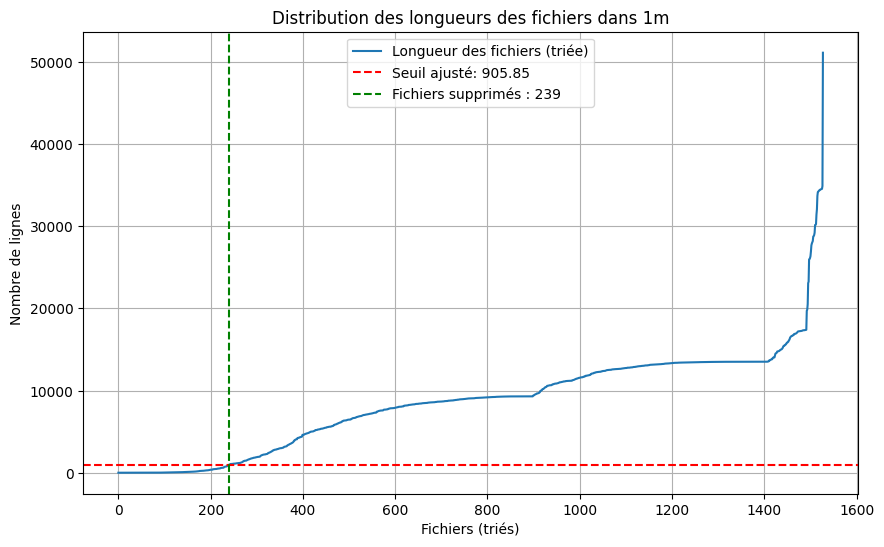


Traitement des fichiers dans l'intervalle : 5m
Seuil pour 5m: 1054.00
Top-10 fichiers pour l'intervalle 5m :
0HEP.L.csv: 1 lignes
0Y2B.L.csv: 4 lignes
0DZB.L.csv: 6 lignes
0DZF.IL.csv: 9 lignes
0GBX.IL.csv: 9 lignes
SNGB.L.csv: 10 lignes
PAWD.L.csv: 12 lignes
FBTC.L.csv: 14 lignes
0MPR.IL.csv: 15 lignes
0MPY.IL.csv: 19 lignes
Nombre de fichiers à conserver : 1342
Nombre de fichiers à supprimer : 200


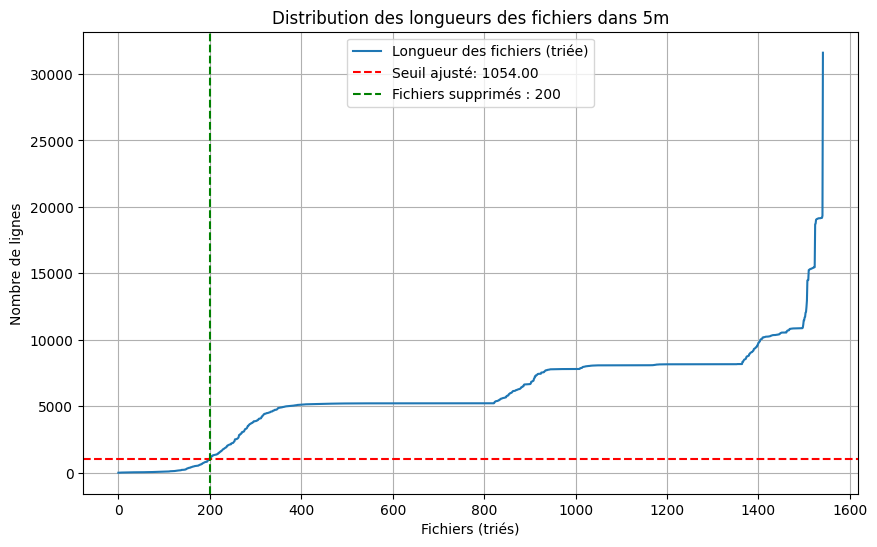


Traitement des fichiers dans l'intervalle : 15m
Seuil pour 15m: 956.00
Top-10 fichiers pour l'intervalle 15m :
0HEP.L.csv: 1 lignes
0Y2B.L.csv: 4 lignes
0DZB.L.csv: 6 lignes
0DZF.IL.csv: 9 lignes
0GBX.IL.csv: 9 lignes
SNGB.L.csv: 9 lignes
PAWD.L.csv: 10 lignes
FBTC.L.csv: 14 lignes
0MPR.IL.csv: 15 lignes
0MPY.IL.csv: 19 lignes
Nombre de fichiers à conserver : 1326
Nombre de fichiers à supprimer : 216


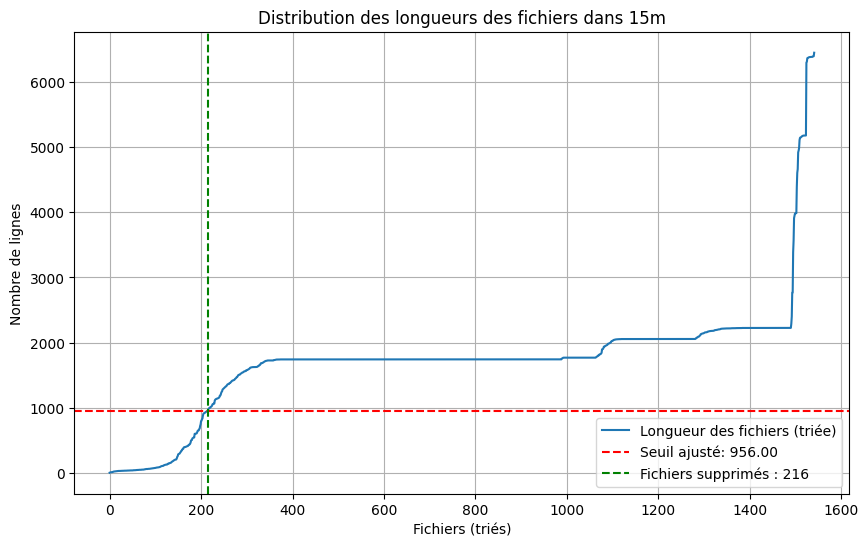


Traitement des fichiers dans l'intervalle : 30m
Seuil pour 30m: 469.50
Top-10 fichiers pour l'intervalle 30m :
0HEP.L.csv: 1 lignes
0Y2B.L.csv: 4 lignes
V3SU.L.csv: 4 lignes
0DZB.L.csv: 6 lignes
JCAU.L.csv: 7 lignes
0DZF.IL.csv: 9 lignes
0GBX.IL.csv: 9 lignes
SNGB.L.csv: 9 lignes
PAWD.L.csv: 10 lignes
EMAU.L.csv: 11 lignes
Nombre de fichiers à conserver : 1353
Nombre de fichiers à supprimer : 189


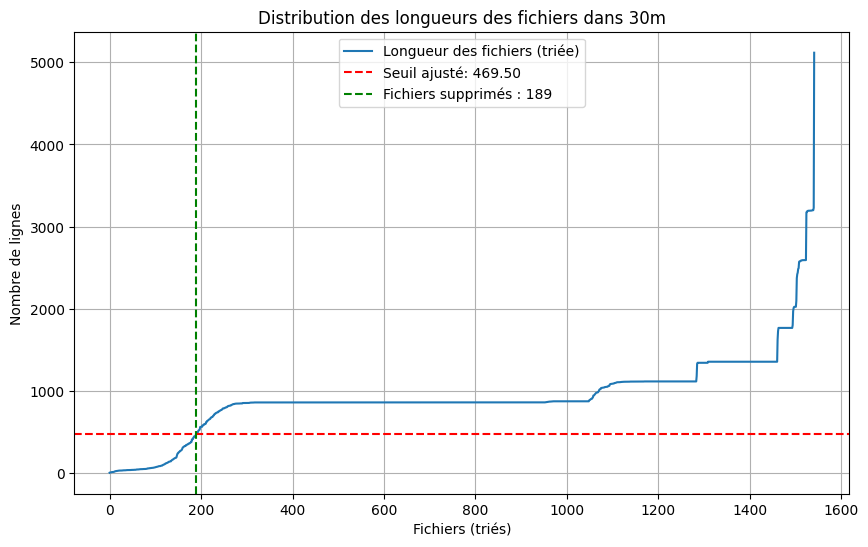


Traitement des fichiers dans l'intervalle : 1h
Seuil pour 1h: 3387.00
Top-10 fichiers pour l'intervalle 1h :
0HEP.L.csv: 5 lignes
JCPN.L.csv: 22 lignes
0Y2B.L.csv: 35 lignes
0MPR.IL.csv: 36 lignes
0MPY.IL.csv: 37 lignes
MTHG.L.csv: 40 lignes
FBTC.L.csv: 48 lignes
0DZB.L.csv: 59 lignes
SSNLF.csv: 62 lignes
JCAU.L.csv: 64 lignes
Nombre de fichiers à conserver : 1302
Nombre de fichiers à supprimer : 230


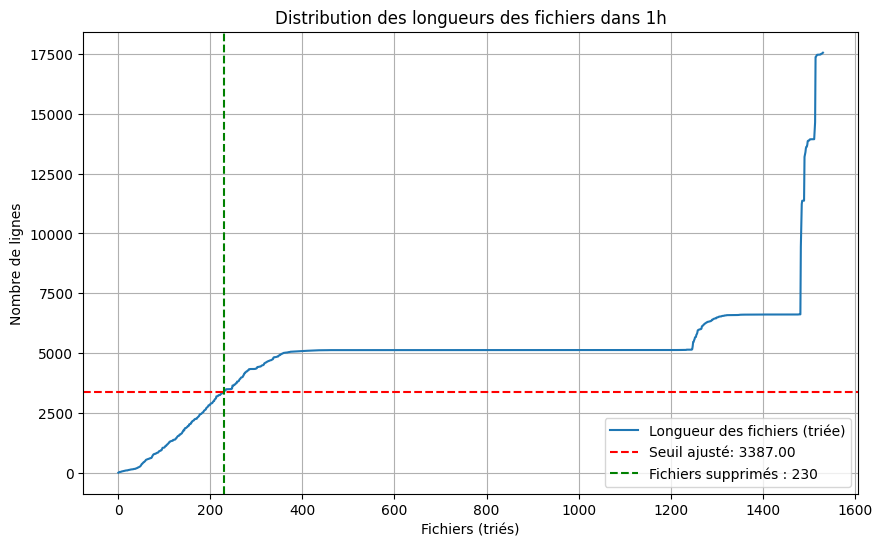


Traitement des fichiers dans l'intervalle : 1d
Seuil pour 1d: 230.05
Top-10 fichiers pour l'intervalle 1d :
0HEP.L.csv: 5 lignes
0MPY.IL.csv: 40 lignes
JCPN.L.csv: 82 lignes
ISRA.PA.csv: 101 lignes
MTHG.L.csv: 111 lignes
0Y2B.L.csv: 113 lignes
0DZB.L.csv: 114 lignes
GRNY.csv: 116 lignes
N100.L.csv: 131 lignes
AVL.csv: 136 lignes
Nombre de fichiers à conserver : 1514
Nombre de fichiers à supprimer : 29


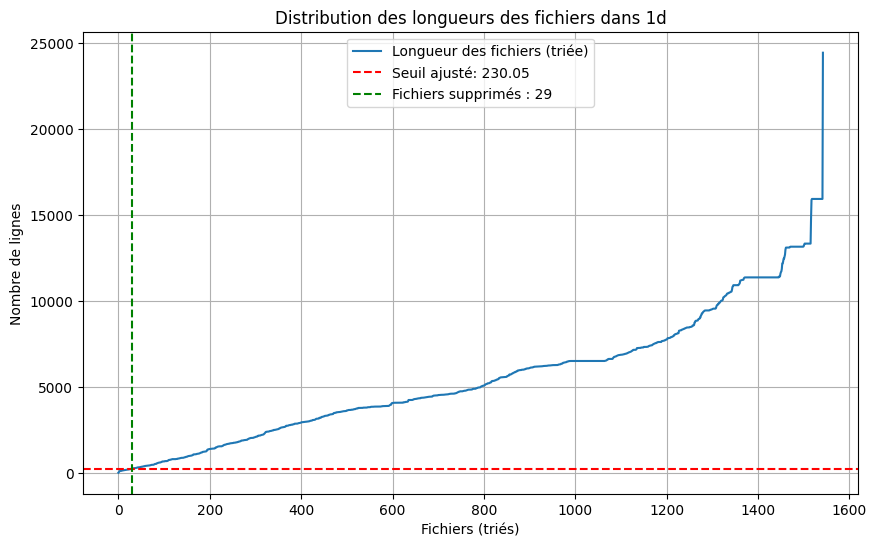


Traitement des fichiers dans l'intervalle : 1m
Seuil pour 1m: 905.85

Traitement des fichiers dans l'intervalle : 5m
Seuil pour 5m: 1054.00

Traitement des fichiers dans l'intervalle : 15m
Seuil pour 15m: 956.00

Traitement des fichiers dans l'intervalle : 30m
Seuil pour 30m: 469.50

Traitement des fichiers dans l'intervalle : 1h
Seuil pour 1h: 3387.00

Traitement des fichiers dans l'intervalle : 1d
Seuil pour 1d: 230.05
INTERVALS définis: ['1m', '5m', '15m', '30m', '1h', '1d']
Traitement des données pour l'intervalle : 1m, 1289 fichiers trouvés


Traitement pour 1m: 100%|██████████| 1289/1289 [00:29<00:00, 43.82it/s]


Intervalle 1m: 1289 fichiers sources, 1289 fichiers traités
Traitement des données pour l'intervalle : 5m, 1344 fichiers trouvés


Traitement pour 5m: 100%|██████████| 1344/1344 [00:23<00:00, 58.20it/s]


Intervalle 5m: 1344 fichiers sources, 1344 fichiers traités
Traitement des données pour l'intervalle : 15m, 1337 fichiers trouvés


Traitement pour 15m: 100%|██████████| 1337/1337 [00:07<00:00, 171.71it/s]


Intervalle 15m: 1337 fichiers sources, 1337 fichiers traités
Traitement des données pour l'intervalle : 30m, 1353 fichiers trouvés


Traitement pour 30m: 100%|██████████| 1353/1353 [00:04<00:00, 279.70it/s]


Intervalle 30m: 1353 fichiers sources, 1353 fichiers traités
Traitement des données pour l'intervalle : 1h, 1303 fichiers trouvés


Traitement pour 1h: 100%|██████████| 1303/1303 [00:18<00:00, 72.13it/s]


Intervalle 1h: 1303 fichiers sources, 1303 fichiers traités
Traitement des données pour l'intervalle : 1d, 1514 fichiers trouvés


Traitement pour 1d: 100%|██████████| 1514/1514 [00:20<00:00, 74.16it/s]


Intervalle 1d: 1514 fichiers sources, 1514 fichiers traités
Intervalle 1m: 1289 fichiers sources, 1289 fichiers traités
Intervalle 5m: 1344 fichiers sources, 1344 fichiers traités
Intervalle 15m: 1337 fichiers sources, 1337 fichiers traités
Intervalle 30m: 1353 fichiers sources, 1353 fichiers traités
Intervalle 1h: 1303 fichiers sources, 1303 fichiers traités
Intervalle 1d: 1514 fichiers sources, 1514 fichiers traités


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Dictionnaire global pour stocker les seuils calculés
seuils = {}

def analyze_and_plot_csv_files_by_iqr(data_dir, intervals, iqr_factor=1.5, top_n=10):
    """
    Analyse les fichiers CSV et calcule les seuils IQR par intervalle. Affiche le top-10 des fichiers les plus courts
    et trace les graphiques.

    Args:
        data_dir (str): Dossier contenant les sous-dossiers d'intervalles.
        intervals (list): Liste des sous-dossiers à traiter.
        iqr_factor (float): Facteur pour le calcul du seuil basé sur l'IQR.
        top_n (int): Nombre de fichiers les plus courts à afficher.
    """
    global seuils  # Accès à la variable globale seuils
    
    for interval in intervals:
        folder_path = os.path.join(data_dir, interval)
        if not os.path.exists(folder_path):
            print(f"Le dossier {folder_path} n'existe pas.")
            continue

        print(f"\nTraitement des fichiers dans l'intervalle : {interval}")
        file_stats = []

        # Lecture des fichiers et comptage des lignes
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path) and filename.endswith('.csv'):
                try:
                    with open(file_path, 'r') as f:
                        num_lines = sum(1 for _ in f) - 1  # Ignorer l'en-tête
                    file_stats.append((num_lines, filename))
                except Exception as e:
                    print(f"Erreur de lecture du fichier {file_path}: {e}")

        if not file_stats:
            print(f"Aucun fichier valide dans {interval}.")
            continue

        # Calcul des quartiles et IQR
        lengths = np.array([num_lines for num_lines, _ in file_stats])
        Q1 = np.percentile(lengths, 20)
        Q3 = np.percentile(lengths, 75)
        IQR = Q3 - Q1

        # Calcul du seuil basé sur l'IQR
        threshold = Q1 - iqr_factor * IQR
        adjusted_iqr_factor = iqr_factor
        while threshold <= 0 and adjusted_iqr_factor > 0.1:  # Réduire le facteur jusqu'à obtenir un seuil positif
            adjusted_iqr_factor /= 2
            threshold = Q1 - adjusted_iqr_factor * IQR

        if threshold <= 0:  # En dernier recours, utiliser une fraction de Q1
            threshold = Q1 * 0.5
            print(f"Seuil ajusté manuellement à une fraction de Q1 : {threshold:.2f}")

        # Stockage du seuil dans la variable globale
        seuils[interval] = threshold
        print(f"Seuil pour {interval}: {threshold:.2f}")

        # Affichage du top-N des fichiers les plus courts
        file_stats.sort()
        print(f"Top-{top_n} fichiers pour l'intervalle {interval} :")
        for num_lines, filename in file_stats[:top_n]:
            print(f"{filename}: {num_lines} lignes")

        # Calcul du nombre de fichiers à conserver et à supprimer
        files_to_keep = [num_lines for num_lines, _ in file_stats if num_lines >= threshold]
        files_to_delete = [num_lines for num_lines, _ in file_stats if num_lines < threshold]

        print(f"Nombre de fichiers à conserver : {len(files_to_keep)}")
        print(f"Nombre de fichiers à supprimer : {len(files_to_delete)}")

        # Plot des longueurs de fichiers avec le seuil
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(lengths)), np.sort(lengths), label='Longueur des fichiers (triée)')
        plt.axhline(y=threshold, color='red', linestyle='--', label=f'Seuil ajusté: {threshold:.2f}')
        
        # Ajouter une ligne verticale pour séparer les fichiers conservés et supprimés
        plt.axvline(x=len(files_to_delete), color='green', linestyle='--', label=f'Fichiers supprimés : {len(files_to_delete)}')

        plt.title(f'Distribution des longueurs des fichiers dans {interval}')
        plt.xlabel('Fichiers (triés)')
        plt.ylabel('Nombre de lignes')
        plt.legend()
        plt.grid(True)
        plt.show()

# Exemple d'exécution
analyze_and_plot_csv_files_by_iqr(DATA_DIR, INTERVALS, iqr_factor=1.5, top_n=10)






























import os
import shutil

def copy_valid_csv_files(data_dir, intervals, seuils, data_dir_enough_data):
    """
    Copie les fichiers CSV dont le nombre de lignes est supérieur au seuil respectif dans un dossier cible.

    Args:
        data_dir (str): Dossier contenant les sous-dossiers d'intervalles.
        intervals (list): Liste des sous-dossiers à traiter.
        seuils (dict): Dictionnaire contenant les seuils calculés pour chaque intervalle.
        data_dir_enough_data (str): Dossier où les fichiers valides seront copiés.
    """
    for interval in intervals:
        folder_path = os.path.join(data_dir, interval)
        if not os.path.exists(folder_path):
            print(f"Le dossier {folder_path} n'existe pas.")
            continue

        # Créer le dossier cible si nécessaire
        target_folder_path = os.path.join(data_dir_enough_data, interval)
        os.makedirs(target_folder_path, exist_ok=True)

        print(f"\nTraitement des fichiers dans l'intervalle : {interval}")

        if interval not in seuils:
            print(f"Aucun seuil trouvé pour l'intervalle {interval}.")
            continue

        threshold = seuils[interval]
        print(f"Seuil pour {interval}: {threshold:.2f}")

        # Lecture des fichiers et comptage des lignes
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path) and filename.endswith('.csv'):
                try:
                    with open(file_path, 'r') as f:
                        num_lines = sum(1 for _ in f) - 1  # Ignorer l'en-tête
                    # Si le fichier a plus de lignes que le seuil, le copier
                    if num_lines >= threshold:
                        target_file_path = os.path.join(target_folder_path, filename)
                        shutil.copy(file_path, target_file_path)  # Copier le fichier
                        #print(f"Fichier copié : {file_path} vers {target_file_path} ({num_lines} lignes)")
                except Exception as e:
                    print(f"Erreur de lecture du fichier {file_path}: {e}")

# Exemple d'exécution

DATA_DIR_ENOUGH_DATA = 'datasets_enough_data'  # Dossier cible pour les données suffisamment longues
copy_valid_csv_files(DATA_DIR, INTERVALS, seuils, DATA_DIR_ENOUGH_DATA)




























import os
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

DATA_DIR_ENOUGH_DATA = 'datasets_enough_data'
TECH_DATA_DIR = 'datasets_technicals'
os.makedirs(DATA_DIR_ENOUGH_DATA, exist_ok=True)
os.makedirs(TECH_DATA_DIR, exist_ok=True)

# Liste pour stocker les erreurs
error_list = []


# Fonction pour charger les données en tenant compte du nom de la colonne de date
def load_data(filename):
    """
    Charge les données CSV et standardise les colonnes de date à 'Date'.
    """
    try:
        if os.path.getsize(filename) == 0:
            print(f"Le fichier {filename} est vide.")
            return None

        # Charger d'abord sans parse_dates pour identifier la colonne de date
        df = pd.read_csv(filename)
        
        # Identifier la colonne de date potentielle
        date_column = None
        for col in df.columns:
            if col.lower() in ['date', 'datetime', 'time', 'timestamp']:
                date_column = col
                break
        
        # Si aucune colonne de date évidente n'est trouvée, essayer la première colonne
        if not date_column and len(df.columns) > 0:
            # Tenter de convertir la première colonne en datetime
            try:
                pd.to_datetime(df.iloc[:, 0])
                date_column = df.columns[0]
            except:
                print(f"Impossible de trouver une colonne de date dans {filename}")
                return None
        
        # Renommer la colonne identifiée en 'Date' si nécessaire
        if date_column and date_column != 'Date':
            df.rename(columns={date_column: 'Date'}, inplace=True)
        
        # Convertir la colonne Date en datetime
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
        else:
            print(f"Aucune colonne 'Date' trouvée ou créée dans {filename}")
            return None

        # Nettoyage des données - supprimer les lignes avant la première valeur valide de Close
        if 'Close' in df.columns:
            first_valid_index = df['Close'].first_valid_index()
            if first_valid_index is not None:
                df = df.loc[first_valid_index:].reset_index(drop=True)
            else:
                print(f"Aucune valeur valide trouvée dans la colonne 'Close' de {filename}.")
                return None

        # Définir Date comme index du DataFrame
        df.set_index('Date', inplace=True)
        
        return df
    except Exception as e:
        error_list.append((filename, f"Erreur lors du chargement: {str(e)}"))
        print(f"Erreur lors du chargement de {filename}: {e}")
        return None

    
    

    

################### ################### ################### ###################  
    
    
# Optimisation des calculs d'indicateurs
def compute_indicators(df):
    if df is None:
        return None

# RSI14:
    def compute_rsi(series, period=14):
        #Calcule le RSI en s'assurant que la série n'a pas de valeurs manquantes.
        # Supprime les NaN pour éviter des erreurs dans le calcul
        series = series.dropna()
        delta = series.diff()  # Différence entre les prix consécutifs
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()  # Gains
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()  # Pertes
        rs = gain / loss  # Rapport des gains et des pertes
        rsi = 100 - (100 / (1 + rs))  # Calcul du RSI
        # Réindexer pour conserver la structure du DataFrame d'origine
        rsi = rsi.reindex(series.index)
        return rsi
    # Calcul du RSI et ajout au DataFrame
    df['RSI14'] = compute_rsi(df['Close'])


# Stochastiques:
    def compute_stochastic(high, low, close, k_period=14, d_period=3):
        # Supprimez les NaN pour éviter des erreurs dans le calcul
        high, low, close = high.dropna(), low.dropna(), close.dropna()
        lowest_low = low.rolling(window=k_period).min()
        highest_high = high.rolling(window=k_period).max()
        k = 100 * (close - lowest_low) / (highest_high - lowest_low)
        d = k.rolling(window=d_period).mean()
        # Réindexer pour conserver la structure du DataFrame d'origine
        k, d = k.reindex(close.index), d.reindex(close.index)
        return k, d
    df['Stochastic_K14'], df['Stochastic_D14'] = compute_stochastic(
        df['High'], df['Low'], df['Close']
    )

# Mean Reversion Channel:
    rolling_mean = df['Close'].dropna().rolling(window=20).mean().reindex(df.index)
    rolling_std = df['Close'].dropna().rolling(window=20).std().reindex(df.index)
    df['MRC_Upper'] = rolling_mean + 2 * rolling_std
    df['MRC_Lower'] = rolling_mean - 2 * rolling_std

# SMA:
    for period in [10, 20, 50, 100, 200]:
        df[f'SMA{period}'] = df['Close'].dropna().rolling(window=period).mean().reindex(df.index)
        
# EMA:
    def compute_ema(series, span):
        series = series.dropna()
        ema = series.ewm(span=span, adjust=False).mean()
        return ema.reindex(series.index)
    for span in [10, 20, 50]:
        df[f'EMA{span}'] = compute_ema(df['Close'], span)

#Volatility:
    
        # Volatilité :
    def compute_volatility(series, window):
        series = series.dropna()
        return series.pct_change().rolling(window=window).std() * np.sqrt(window)
    for window in [20, 50, 100, 360]:
        df[f'Volatility{window}'] = compute_volatility(df['Close'], window)

        
        
# Paramètres pour le Monte Carlo (méthode de Heston)
    # Calcul des rendements journaliers moyens pour le modèle GBM
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['mu'] = df['log_return'].mean()  # Taux de rendement moyen

    def compute_heston_params(df):
        try:
            volatility_100 = df['Volatility100'].dropna()
            volatility_360 = df['Volatility360'].dropna()

            if len(volatility_100) < 10 or len(volatility_360) < 10:
                return np.nan, np.nan, np.nan

            ema_volatility_100 = volatility_100.ewm(span=100, adjust=False).mean()
            ema_volatility_360 = volatility_360.ewm(span=360, adjust=False).mean()

            theta = np.mean([ema_volatility_100.iloc[-1], ema_volatility_360.iloc[-1]])
            sigma_v = np.std(volatility_360)
            kappa = min(max(1 / np.mean(volatility_360.pct_change().dropna()), 0.1), 10)

            return theta, sigma_v, kappa
        except Exception as e:
            print(f"Error computing Heston params: {e}")
            return np.nan, np.nan, np.nan

    # Calcul des paramètres pour Heston
    theta, sigma_v, kappa = compute_heston_params(df)
    df['theta'] = theta
    df['sigma_v'] = sigma_v
    df['kappa'] = kappa


        
#Momentum(%):
    def compute_momentum(df, periods):
        for period in periods:
            df['Close'] = df['Close'].ffill()  # Remplir les NaN en avant
            df[f'Momentum{period}'] = df['Close'].pct_change(periods=period) * 100
    compute_momentum(df, [20, 50, 100, 252, 360])

            
    return df


################### ################### ################### ###################  





# Fonction pour traiter un ticker et un intervalle
def process_data_for_ticker_and_interval(ticker, interval):
    source_path = os.path.join(DATA_DIR_ENOUGH_DATA, interval, f"{ticker}.csv")
    if not os.path.exists(source_path):
        error_list.append((ticker, interval, "Fichier manquant"))
        #print(f"Fichier manquant pour {ticker} : {source_path}")
        return

    df = load_data(source_path)
    if df is None:
        error_list.append((ticker, interval, "Erreur lors du chargement"))
        return
    df.name = ticker # Assigner un nom au DataFrame

    # Calcul des indicateurs
    df_with_indicators = compute_indicators(df)

    # Sauvegarder les données modifiées dans le sous-dossier TECH_DATA_DIR
    if df_with_indicators is not None:
        destination_path = os.path.join(TECH_DATA_DIR, interval, f"{ticker}.csv")
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        df_with_indicators.to_csv(destination_path)
    else:
        print(f"Aucun indicateur calculé pour {ticker}, DataFrame vide.")
        
def process_all_data():
    print(f"INTERVALS définis: {INTERVALS}")
    for interval in INTERVALS:
        interval_path = os.path.join(DATA_DIR_ENOUGH_DATA, interval)
        if not os.path.exists(interval_path):
            print(f"Le dossier {interval_path} n'existe pas.")
            continue
        
        # Obtenir la liste des fichiers réellement présents dans le dossier
        csv_files = [f[:-4] for f in os.listdir(interval_path) if f.endswith('.csv')]
        file_count = len(csv_files)
        print(f"Traitement des données pour l'intervalle : {interval}, {file_count} fichiers trouvés")
        
        # Créer le dossier de destination s'il n'existe pas
        os.makedirs(os.path.join(TECH_DATA_DIR, interval), exist_ok=True)

        # Créer un compteur de réussite/échec
        success_count = 0
        error_count = 0
               
        # Continuer avec le traitement parallèle
        results = Parallel(n_jobs=-1)(
            delayed(process_data_for_ticker_and_interval)(ticker, interval)
            for ticker in tqdm(csv_files, desc=f"Traitement pour {interval}")
        )
        
        # Vérifier le résultat final
        dest_path = os.path.join(TECH_DATA_DIR, interval)
        dest_files = len([f for f in os.listdir(dest_path) if f.endswith('.csv')])
        print(f"Intervalle {interval}: {file_count} fichiers sources, {dest_files} fichiers traités")


# Lancer le traitement
process_all_data()

# À ajouter à la fin de votre script
for interval in INTERVALS:
    source_path = os.path.join(DATA_DIR_ENOUGH_DATA, interval)
    dest_path = os.path.join(TECH_DATA_DIR, interval)
    
    if os.path.exists(source_path) and os.path.exists(dest_path):
        source_files = len([f for f in os.listdir(source_path) if f.endswith('.csv')])
        dest_files = len([f for f in os.listdir(dest_path) if f.endswith('.csv')])
        
        print(f"Intervalle {interval}: {source_files} fichiers sources, {dest_files} fichiers traités")

In [7]:
DATA_INTERVAL = '1d'




import matplotlib.pyplot as plt
import pandas as pd
import os
#DATA_INTERVAL='1d'

def plot_simple_coverage(data_dir, interval):
    """
    Crée un plot simple montrant toutes les dates de tous les fichiers,
    triés par nombre de dates croissant.
    """
    folder_path = os.path.join(data_dir, interval)
    
    # Collecter les informations de dates pour chaque ticker
    ticker_info = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            ticker = filename[:-4]
            df = pd.read_csv(os.path.join(folder_path, filename))
            dates = pd.to_datetime(df['Date'])
            ticker_info.append({
                'ticker': ticker,
                'start': dates.min(),
                'end': dates.max(),
                'count': len(dates)
            })
    
    # Trier par nombre de dates
    ticker_info = sorted(ticker_info, key=lambda x: -x['count'])
    
    plt.figure(figsize=(20, max(10, len(ticker_info)/4)))
    
    # Tracer les lignes dans l'ordre trié
    for i, info in enumerate(ticker_info):
        plt.plot([info['start'], info['end']], [i, i], '-', 
                linewidth=2, label=info['ticker'])
    
    plt.grid(True, alpha=0.3)
    plt.title(f'Couverture temporelle par ticker ({interval})\nTrié par nombre de dates croissant')
    plt.xlabel('Date')
    plt.ylabel('Ticker')
    plt.yticks(range(len(ticker_info)), 
               [f"{info['ticker']} ({info['count']})" for info in ticker_info])
    plt.tight_layout()
    
    return plt.gcf()

# Créer la visualisation
fig = plot_simple_coverage(TECH_DATA_DIR, DATA_INTERVAL)

